## 1. PREPROCESSING AND STANDARDIZATION

### 1.1 Standardization

In [ ]:
# Standardize essays in a CSV file
import pandas as pd
import nltk
import re
from nltk.tokenize import sent_tokenize

# Download tokenizer
try:
    nltk.download('punkt_tab')
except:
    nltk.download('punkt')

def standardize_essay(text):
    """
    Standardizes a single essay:
    - Splits paragraphs on double newlines
    - Splits sentences within paragraphs
    - Ensures one sentence per line
    - Ensures paragraphs are separated by double newlines
    """
    standardized_paragraphs = []
    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
    
    for p in paragraphs:
        sentences = sent_tokenize(p)
        standardized_paragraphs.append('\n'.join(sentences))
    
    standardized_text = '\n\n'.join(standardized_paragraphs)
    return standardized_text

def extract_overall_score(evaluation_text):
    """
    Extracts the overall score (last number) from the evaluation column.
    Looks for numbers that could be scores (integers or decimals).
    """
    if pd.isna(evaluation_text):
        return None
    
    # Find all numbers (integers and decimals) in the text
    numbers = re.findall(r'\b\d+(?:\.\d+)?\b', str(evaluation_text))
    
    if numbers:
        # Return the last number found (overall score)
        return float(numbers[-1])
    
    return None

def standardize_band(band_value):
    """
    Standardizes band score format:
    - Removes leading/trailing whitespace
    - Ensures consistent format (e.g., "4.5")
    """
    if pd.isna(band_value):
        return None
    
    # Convert to string and strip whitespace
    band_str = str(band_value).strip()
    
    # Try to convert to float and back to string for consistent format
    try:
        band_float = float(band_str)
        # Format to one decimal place if it's a decimal, otherwise as integer
        if band_float % 1 == 0:
            return f"{band_float:.1f}"
        else:
            return str(band_float)
    except ValueError:
        # If conversion fails, return the stripped string
        return band_str

# === Load CSV ===
input_csv = "ielts_writing_full_1.csv"  # replace with your file path
df = pd.read_csv(input_csv)

# === Standardize essays ===
df['standardized_essay'] = df['essay'].apply(standardize_essay)

# === Extract overall score ===
df['overall_score'] = df['evaluation'].apply(extract_overall_score)

# === Standardize band column ===
df['band'] = df['band'].apply(standardize_band)

# === Save to new CSV ===
output_csv = "essays_standardized.csv"  # replace with desired output path
df.to_csv(output_csv, index=False)

print(f"Standardized essays saved to {output_csv}")
print(f"Overall scores extracted from 'evaluation' column")
print(f"Band scores standardized and whitespace removed")

### 1.2 RST Features Extraction

In [ ]:
# RST Features Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from datetime import datetime


def calculate_tree_layout(node, x=0, y=0, level_width=4.5, min_spacing=3):
    """
    Calculate positions for each node in the tree (horizontal layout: left to right).
    Returns a dictionary mapping node ids to (x, y) positions.
    """
    positions = {}
    heights = {}
    
    def calculate_height(node):
        """Calculate the height needed for this subtree"""
        if node is None:
            return 0
        
        has_children = hasattr(node, 'left') and hasattr(node, 'right') and node.left is not None
        
        if not has_children:
            # Leaf node
            heights[id(node)] = min_spacing
            return min_spacing
        
        left_height = calculate_height(node.left) if node.left else 0
        right_height = calculate_height(node.right) if node.right else 0
        total_height = left_height + right_height
        heights[id(node)] = total_height
        return total_height
    
    def assign_positions(node, x, y):
        """Assign x, y positions to each node (horizontal tree)"""
        if node is None:
            return
        
        has_children = hasattr(node, 'left') and hasattr(node, 'right') and node.left is not None
        
        if not has_children:
            # Leaf node
            positions[id(node)] = (x, y)
            return
        
        # Internal node
        positions[id(node)] = (x, y)
        
        # Position children (going RIGHT and spreading vertically)
        left_height = heights.get(id(node.left), 0) if node.left else 0
        right_height = heights.get(id(node.right), 0) if node.right else 0
        
        if node.left:
            left_y = y + right_height / 2
            assign_positions(node.left, x + level_width, left_y)
        
        if node.right:
            right_y = y - left_height / 2
            assign_positions(node.right, x + level_width, right_y)
    
    # First calculate heights
    calculate_height(node)
    # Then assign positions
    assign_positions(node, x, y)
    
    return positions


def draw_rst_tree(node, text, output_pdf='rst_tree.pdf', figsize=(24, 16)):
    """
    Draw RST tree horizontally (left to right) and save to PDF.
    
    Args:
        node: Root DiscourseUnit
        text: Original text for EDU content
        output_pdf: Output PDF filename
        figsize: Figure size tuple (width, height) - horizontal layout
    """
    # Calculate layout
    positions = calculate_tree_layout(node)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Collections for drawing
    edges = []
    node_data = []
    
    def collect_tree_data(node):
        """Collect all nodes and edges for drawing"""
        if node is None:
            return
        
        node_id = id(node)
        pos = positions[node_id]
        has_children = hasattr(node, 'left') and hasattr(node, 'right') and node.left is not None
        
        if has_children:
            # Internal node
            relation = getattr(node, 'relation', 'Unknown')
            nuclearity = getattr(node, 'nuclearity', 'NN')
            label = f"{relation}\n({nuclearity})"
            
            node_data.append({
                'pos': pos,
                'label': label,
                'type': 'internal',
                'nuclearity': nuclearity
            })
            
            # Draw edges to children
            if node.left:
                child_pos = positions[id(node.left)]
                left_nuc = nuclearity[0] if len(nuclearity) > 0 else 'N'
                edges.append((pos, child_pos, left_nuc))
                collect_tree_data(node.left)
            
            if node.right:
                child_pos = positions[id(node.right)]
                right_nuc = nuclearity[1] if len(nuclearity) > 1 else 'N'
                edges.append((pos, child_pos, right_nuc))
                collect_tree_data(node.right)
        else:
            # Leaf EDU - show only partial text
            start = getattr(node, 'start', 0)
            end = getattr(node, 'end', 0)
            edu_text = text[start:end].strip() if text else ''
            
            # Show only first 80 characters
            if len(edu_text) > 80:
                edu_text = edu_text[:27] + "..."
            
            edu_id = getattr(node, 'id', '?')
            # Just show the text without EDU label for cleaner look
            label = edu_text
            
            node_data.append({
                'pos': pos,
                'label': label,
                'type': 'leaf',
                'edu_id': edu_id
            })
    
    # Collect all data
    collect_tree_data(node)
    
    # Draw edges first (so they appear behind nodes)
    for start_pos, end_pos, nuclearity in edges:
        # Different line styles for nucleus vs satellite
        if nuclearity == 'N':
            linestyle = '-'
            linewidth = 1
            color = 'black'
        else:  # 'S'
            linestyle = '--'
            linewidth = 0.5
            color = 'gray'
        
        ax.plot([start_pos[0], end_pos[0]], 
                [start_pos[1], end_pos[1]], 
                linestyle=linestyle, 
                linewidth=linewidth, 
                color=color, 
                zorder=1)
    
    # Draw nodes (bigger boxes)
    for node_info in node_data:
        pos = node_info['pos']
        label = node_info['label']
        
        if node_info['type'] == 'internal':
            # Internal node - bigger rectangle
            box_width = 3.5
            box_height = 2
            rect = mpatches.FancyBboxPatch(
                (pos[0] - box_width/2, pos[1] - box_height/2),
                box_width, box_height,
                boxstyle="round,pad=0.1",
                edgecolor='blue',
                facecolor='lightblue',
                linewidth=2.5,
                zorder=2
            )
            ax.add_patch(rect)
            ax.text(pos[0], pos[1], label, 
                   ha='center', va='center', 
                   fontsize=6, fontweight='bold',
                   zorder=3)
        else:
            # Leaf node - just text, no box
            ax.text(pos[0], pos[1], label, 
                   ha='left', va='center', 
                   fontsize=6,
                   zorder=3)
    
    # Add legend
    internal_patch = mpatches.Rectangle((0, 0), 1, 1, 
                                       facecolor='lightblue', 
                                       edgecolor='blue', 
                                       linewidth=2.5,
                                       label='Internal Node (Relation)')
    leaf_patch = mpatches.Patch(facecolor='white', 
                               edgecolor='white', 
                               linewidth=2.5,
                               label='Leaf Node (EDU)')
    nucleus_line = mpatches.Patch(color='black', label='Nucleus (solid)')
    satellite_line = mpatches.Patch(color='gray', label='Satellite (dashed)')
    
    ax.legend(handles=[internal_patch, leaf_patch, nucleus_line, satellite_line],
             loc='upper right', fontsize=11)
    
    # Set axis limits with padding
    if positions:
        x_coords = [pos[0] for pos in positions.values()]
        y_coords = [pos[1] for pos in positions.values()]
        x_margin = (max(x_coords) - min(x_coords)) * 0.1 + 2
        y_margin = (max(y_coords) - min(y_coords)) * 0.1 + 2
        ax.set_xlim(min(x_coords) - x_margin, max(x_coords) + x_margin)
        ax.set_ylim(min(y_coords) - y_margin, max(y_coords) + y_margin)
    
    plt.title('RST Tree Visualization', fontsize=18, fontweight='bold', pad=20)
    plt.tight_layout()
    
    # Save to PDF
    with PdfPages(output_pdf) as pdf:
        pdf.savefig(fig, bbox_inches='tight')
        
        # Add metadata
        d = pdf.infodict()
        d['Title'] = 'RST Tree Visualization'
        d['Author'] = 'RST Parser'
        d['Subject'] = 'Rhetorical Structure Theory Tree'
        d['CreationDate'] = datetime.now()
    
    plt.close()
    print(f"✓ PDF saved to: {output_pdf}")




### 1.3 Test and Visualize on an Example Essay

In [ ]:
# Test Parser on Example Essay
import numpy as np
import spacy
import torch
from isanlp_rst.parser import Parser
from isanlp.annotation_rst import DiscourseUnit
import isanlp_rst
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

def print_rst_tree(node, depth=0, text=None):
    """
    Pretty-print an RST tree recursively.
    
    Args:
        node: DiscourseUnit object (can be internal node or leaf EDU)
        text: full essay text, used to show EDU text
        depth: indentation for pretty printing
    """
    indent = "  " * depth
    
    # All nodes are DiscourseUnit objects
    # Check if it's an internal node (has children) or leaf (no children)
    has_children = hasattr(node, 'left') and hasattr(node, 'right') and node.left is not None
    
    if has_children:
        # Internal node (has left and right children)
        relation = getattr(node, 'relation', 'Unknown')
        nuclearity = getattr(node, 'nuclearity', 'Unknown')
        node_id = getattr(node, 'id', 'N/A')
        start = getattr(node, 'start', '?')
        end = getattr(node, 'end', '?')
        
        print(f"{indent}[Node {node_id}] {relation} ({nuclearity}) | span: ({start}, {end})")
        
        # Recurse into children
        if node.left is not None:
            print(f"{indent}  ├─ Left:")
            print_rst_tree(node.left, depth + 2, text)
        
        if node.right is not None:
            print(f"{indent}  └─ Right:")
            print_rst_tree(node.right, depth + 2, text)
    
    else:
        # Leaf EDU (no children)
        edu_id = getattr(node, 'id', 'N/A')
        start = getattr(node, 'start', 0)
        end = getattr(node, 'end', 0)
        
        if text:
            edu_text = text[start:end].strip()
            # Truncate long text
            if len(edu_text) > 100:
                edu_text = edu_text[:97] + "..."
        else:
            edu_text = getattr(node, 'text', '[no text]')
            if len(edu_text) > 100:
                edu_text = edu_text[:97] + "..."
        
        print(f"{indent}[EDU {edu_id}] span: ({start}, {end})")
        print(f"{indent}  └─ \"{edu_text}\"")


def extract_rst_statistics(node):
    """
    Extract statistics from RST tree.
    
    Returns:
        dict with tree statistics
    """
    stats = {
        'total_nodes': 0,
        'total_edus': 0,
        'max_depth': 0,
        'relations': [],
        'nuclearity_counts': {'NN': 0, 'NS': 0, 'SN': 0}
    }
    
    def traverse(node, depth=0):
        if node is None:
            return
            
        stats['max_depth'] = max(stats['max_depth'], depth)
        
        # Check if internal node (has children)
        has_children = hasattr(node, 'left') and hasattr(node, 'right') and node.left is not None
        
        if has_children:
            stats['total_nodes'] += 1
            relation = getattr(node, 'relation', 'Unknown')
            nuclearity = getattr(node, 'nuclearity', 'Unknown')
            
            stats['relations'].append(relation)
            if nuclearity in stats['nuclearity_counts']:
                stats['nuclearity_counts'][nuclearity] += 1
            
            # Recurse
            traverse(node.left, depth + 1)
            traverse(node.right, depth + 1)
        else:
            # Leaf EDU
            stats['total_edus'] += 1
    
    traverse(node)
    return stats


# === Parser setup ===
print("="*80)
print("RST Parser Setup")
print("="*80)

version = 'rstdt'
parser = Parser(
    hf_model_name='tchewik/isanlp_rst_v3',
    hf_model_version=version,
    cuda_device=-1  
)

print(f"✓ Parser loaded: {version} model")
print()

# === Example text ===
text = """
Preserving the natural environment has become very crucial as manufacturing of consumer products on a large scale has led to environmental disturbance. 
People's needs have changed over time, which has caused immense damage to the natural surroundings. 
There are many ways this issue can be controlled. 
We shall continue to discuss in the next paragraphs.

Cutting down trees is the major cause of natural imbalance. 
In our lives, plants and trees are the major source of fresh air. 
Trees have been cut down to meet the increased demand for rubber, paper, and other products. 
The government should impose heavy fines on such people or they should be imprisoned if they cause harm to these natural resources.

Another important cause of the extinction of natural resources is the increased demand for land. 
Mountains, forests, and barren fields are being used to construct huge buildings and malls. 
Such land should be used for growing or planting more trees instead of selling thousands of acres to MNCs or selfish builders. 
Educating children at a young age can help preserve these precious resources from extinction.

To conclude, civilians and government should go hand in hand to preserve these resources. 
Instead of overusing natural resources, alternative ways should be found to meet the increased demands of the population.
"""

print("="*80)
print("Essay Text")
print("="*80)
print(text.strip())
print()

# === Parse and print tree ===
print("="*80)
print("Parsing Essay...")
print("="*80)

res = parser(text)
root = res['rst'][0]

print("\n" + "="*80)
print("RST Tree Structure")
print("="*80)
print_rst_tree(root, text=text)

# === Extract and display statistics ===
print("\n" + "="*80)
print("RST Tree Statistics")
print("="*80)

stats = extract_rst_statistics(root)
print(f"Total Internal Nodes: {stats['total_nodes']}")
print(f"Total EDUs (Leaf Units): {stats['total_edus']}")
print(f"Maximum Tree Depth: {stats['max_depth']}")

print(f"\nNuclearity Distribution:")
total_nuclearity = sum(stats['nuclearity_counts'].values())
if total_nuclearity > 0:
    print(f"  - NN (Nucleus-Nucleus): {stats['nuclearity_counts']['NN']} ({stats['nuclearity_counts']['NN']/total_nuclearity*100:.1f}%)")
    print(f"  - NS (Nucleus-Satellite): {stats['nuclearity_counts']['NS']} ({stats['nuclearity_counts']['NS']/total_nuclearity*100:.1f}%)")
    print(f"  - SN (Satellite-Nucleus): {stats['nuclearity_counts']['SN']} ({stats['nuclearity_counts']['SN']/total_nuclearity*100:.1f}%)")
else:
    print("  No nuclearity data found")

if stats['relations']:
    print(f"\nRelation Types Found:")
    unique_relations = set(stats['relations'])
    for relation in sorted(unique_relations):
        count = stats['relations'].count(relation)
        percentage = (count / len(stats['relations'])) * 100
        print(f"  - {relation}: {count} ({percentage:.1f}%)")
else:
    print("\nNo relations found")

print("\n" + "="*80)
print("Root Node Details")
print("="*80)
print(f"ID: {root.id}")
print(f"Relation: {root.relation}")
print(f"Nuclearity: {root.nuclearity}")
print(f"Span: ({root.start}, {root.end})")
print(f"Has children: {root.left is not None}")

print("\n✓ Analysis complete!")

# After parsing:
res = parser(text)
root = res['rst'][0]

# Generate PDF visualization
# Use vertical layout with bigger nodes
draw_rst_tree(root, text, output_pdf='rst_tree_visualization.pdf', figsize=(24, 16))



### 1.4 Extract RST Features for The Whole Dataset

In [ ]:
# RST Parser For The Whole Dataset (CSV)
import pandas as pd
import numpy as np
from isanlp_rst.parser import Parser
from isanlp.annotation_rst import DiscourseUnit

def extract_rst_statistics(node):
    """
    Extract statistics from RST tree.
    
    Returns:
        dict with tree statistics
    """
    stats = {
        'total_nodes': 0,
        'total_edus': 0,
        'max_depth': 0,
        'relations': [],
        'nuclearity_counts': {'NN': 0, 'NS': 0, 'SN': 0}
    }
    
    def traverse(node, depth=0):
        if node is None:
            return
            
        stats['max_depth'] = max(stats['max_depth'], depth)
        
        # Check if internal node (has children)
        has_children = hasattr(node, 'left') and hasattr(node, 'right') and node.left is not None
        
        if has_children:
            stats['total_nodes'] += 1
            relation = getattr(node, 'relation', 'Unknown')
            nuclearity = getattr(node, 'nuclearity', 'Unknown')
            
            stats['relations'].append(relation)
            if nuclearity in stats['nuclearity_counts']:
                stats['nuclearity_counts'][nuclearity] += 1
            
            # Recurse
            traverse(node.left, depth + 1)
            traverse(node.right, depth + 1)
        else:
            # Leaf EDU
            stats['total_edus'] += 1
    
    traverse(node)
    return stats


def process_essay_rst(essay_text, parser):
    """
    Process a single essay and return RST statistics as a dict.
    """
    try:
        if pd.isna(essay_text) or not essay_text.strip():
            return {
                'NN_count': None, 'NS_count': None, 'SN_count': None,
                'NN_ratio': None, 'NS_ratio': None, 'SN_ratio': None,
                'main_nuclearity': None,
                'relation_counts': None,
                'relation_ratios': None,
                'main_relation': None,
                'total_edus': None,
                'max_depth': None
            }
        
        # Parse the essay
        res = parser(essay_text)
        root = res['rst'][0]
        
        # Extract statistics
        stats = extract_rst_statistics(root)
        
        # Calculate nuclearity ratios
        total_nuclearity = sum(stats['nuclearity_counts'].values())
        if total_nuclearity > 0:
            nn_ratio = stats['nuclearity_counts']['NN'] / total_nuclearity
            ns_ratio = stats['nuclearity_counts']['NS'] / total_nuclearity
            sn_ratio = stats['nuclearity_counts']['SN'] / total_nuclearity
            
            # Find main nuclearity (most common)
            main_nuclearity = max(stats['nuclearity_counts'], key=stats['nuclearity_counts'].get)
        else:
            nn_ratio = ns_ratio = sn_ratio = 0
            main_nuclearity = None
        
        # Calculate relation statistics
        if stats['relations']:
            from collections import Counter
            relation_counter = Counter(stats['relations'])
            
            # Get counts and ratios as strings
            relation_counts = '; '.join([f"{rel}: {count}" for rel, count in relation_counter.most_common()])
            relation_ratios = '; '.join([f"{rel}: {count/len(stats['relations']):.3f}" for rel, count in relation_counter.most_common()])
            
            # Main relation (most common)
            main_relation = relation_counter.most_common(1)[0][0]
        else:
            relation_counts = None
            relation_ratios = None
            main_relation = None
        
        return {
            'NN_count': stats['nuclearity_counts']['NN'],
            'NS_count': stats['nuclearity_counts']['NS'],
            'SN_count': stats['nuclearity_counts']['SN'],
            'NN_ratio': round(nn_ratio, 3),
            'NS_ratio': round(ns_ratio, 3),
            'SN_ratio': round(sn_ratio, 3),
            'main_nuclearity': main_nuclearity,
            'relation_counts': relation_counts,
            'relation_ratios': relation_ratios,
            'main_relation': main_relation,
            'total_edus': stats['total_edus'],
            'max_depth': stats['max_depth']
        }
    
    except Exception as e:
        print(f"Error processing essay: {e}")
        return {
            'NN_count': None, 'NS_count': None, 'SN_count': None,
            'NN_ratio': None, 'NS_ratio': None, 'SN_ratio': None,
            'main_nuclearity': None,
            'relation_counts': None,
            'relation_ratios': None,
            'main_relation': None,
            'total_edus': None,
            'max_depth': None
        }


# === Setup ===
print("="*80)
print("RST Parser Setup")
print("="*80)

version = 'rstdt'
parser = Parser(
    hf_model_name='tchewik/isanlp_rst_v3',
    hf_model_version=version,
    cuda_device=-1  
)

print(f"✓ Parser loaded: {version} model")
print()

# === Load CSV ===
input_csv = "essays_standardized.csv"
print(f"Loading {input_csv}...")
df = pd.read_csv(input_csv)
print(f"✓ Loaded {len(df)} essays")
print()

# === Process each essay ===
print("="*80)
print("Processing Essays...")
print("="*80)

results = []
for idx, essay in enumerate(df['standardized_essay'], 1):
    print(f"Processing essay {idx}/{len(df)}...", end='\r')
    result = process_essay_rst(essay, parser)
    results.append(result)

print(f"\n✓ Processed {len(results)} essays")
print()

# === Add results to dataframe ===
results_df = pd.DataFrame(results)
df = pd.concat([df, results_df], axis=1)

# === Save to new CSV ===
output_csv = "essays_with_rst.csv"
df.to_csv(output_csv, index=False)

print("="*80)
print("Complete!")
print("="*80)
print(f"✓ Results saved to {output_csv}")
print(f"\nNew columns added:")
print("  - NN_count, NS_count, SN_count")
print("  - NN_ratio, NS_ratio, SN_ratio")
print("  - main_nuclearity")
print("  - relation_counts")
print("  - relation_ratios")
print("  - main_relation")
print("  - total_edus")
print("  - max_depth")

### 1.5 Extract Lexical & Syntactic Features

In [ ]:
# Extract Lexical & Syntactic Features
import pandas as pd
import spacy
import textstat
from wordfreq import word_frequency
from collections import Counter
import numpy as np

def extract_lexical_features(text, nlp):
    """
    Extract Surface and Lexical Features (LR):
    - Word count, sentence count, avg sentence length
    - Type-token ratio (TTR)
    - Lexical diversity metrics
    - Readability scores (Flesch Reading Ease, Flesch-Kincaid Grade)
    - Word frequency metrics
    """
    try:
        if pd.isna(text) or not text.strip():
            return {f'lex_{k}': None for k in [
                'word_count', 'sent_count', 'avg_sent_len', 'ttr', 
                'flesch_reading_ease', 'flesch_kincaid_grade',
                'avg_word_freq', 'rare_word_ratio'
            ]}
        
        doc = nlp(text)
        
        # Basic counts
        words = [token for token in doc if not token.is_punct and not token.is_space]
        word_count = len(words)
        sent_count = len(list(doc.sents))
        avg_sent_len = word_count / sent_count if sent_count > 0 else 0
        
        # Type-Token Ratio (lexical diversity)
        word_texts = [token.text.lower() for token in words]
        unique_words = len(set(word_texts))
        ttr = unique_words / word_count if word_count > 0 else 0
        
        # Readability scores
        flesch_reading_ease = textstat.flesch_reading_ease(text)
        flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
        
        # Word frequency analysis (using wordfreq)
        word_freqs = [word_frequency(token.text.lower(), 'en') for token in words]
        avg_word_freq = np.mean(word_freqs) if word_freqs else 0
        
        # Rare word ratio (words with frequency < 1e-5)
        rare_words = sum(1 for freq in word_freqs if freq < 1e-5)
        rare_word_ratio = rare_words / word_count if word_count > 0 else 0
        
        return {
            'lex_word_count': word_count,
            'lex_sent_count': sent_count,
            'lex_avg_sent_len': round(avg_sent_len, 2),
            'lex_ttr': round(ttr, 3),
            'lex_flesch_reading_ease': round(flesch_reading_ease, 2),
            'lex_flesch_kincaid_grade': round(flesch_kincaid_grade, 2),
            'lex_avg_word_freq': round(avg_word_freq, 6),
            'lex_rare_word_ratio': round(rare_word_ratio, 3)
        }
    
    except Exception as e:
        print(f"Error in lexical features: {e}")
        return {f'lex_{k}': None for k in [
            'word_count', 'sent_count', 'avg_sent_len', 'ttr',
            'flesch_reading_ease', 'flesch_kincaid_grade',
            'avg_word_freq', 'rare_word_ratio'
        ]}


def extract_syntactic_features(text, nlp):
    """
    Extract Morphological and Syntactic Complexity (GR):
    - POS tag distribution (noun, verb, adj, adv ratios)
    - Dependency relation distribution
    - Average dependency tree depth
    - Subordinate clause count
    - Passive voice count
    """
    try:
        if pd.isna(text) or not text.strip():
            return {f'syn_{k}': None for k in [
                'noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio',
                'avg_tree_depth', 'subordinate_ratio', 'passive_ratio',
                'dep_relation_diversity', 'main_dep_relation'
            ]}
        
        doc = nlp(text)
        
        # Get all tokens (excluding punctuation and spaces)
        tokens = [token for token in doc if not token.is_punct and not token.is_space]
        token_count = len(tokens)
        
        if token_count == 0:
            return {f'syn_{k}': None for k in [
                'noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio',
                'avg_tree_depth', 'subordinate_ratio', 'passive_ratio',
                'dep_relation_diversity', 'main_dep_relation'
            ]}
        
        # POS tag distribution
        pos_counts = Counter([token.pos_ for token in tokens])
        noun_ratio = (pos_counts['NOUN'] + pos_counts['PROPN']) / token_count
        verb_ratio = pos_counts['VERB'] / token_count
        adj_ratio = pos_counts['ADJ'] / token_count
        adv_ratio = pos_counts['ADV'] / token_count
        
        # Dependency relations
        dep_relations = [token.dep_ for token in tokens]
        dep_counter = Counter(dep_relations)
        
        # Dependency relation diversity (unique deps / total deps)
        dep_relation_diversity = len(set(dep_relations)) / len(dep_relations) if dep_relations else 0
        
        # Main dependency relation (most common)
        main_dep_relation = dep_counter.most_common(1)[0][0] if dep_counter else None
        
        # Average dependency tree depth
        def get_depth(token):
            depth = 0
            while token.head != token:
                depth += 1
                token = token.head
            return depth
        
        depths = [get_depth(token) for token in tokens]
        avg_tree_depth = np.mean(depths) if depths else 0
        
        # Subordinate clause count (clauses with 'mark' or 'advcl' dependency)
        subordinate_count = sum(1 for token in tokens if token.dep_ in ['mark', 'advcl', 'ccomp', 'xcomp'])
        subordinate_ratio = subordinate_count / token_count
        
        # Passive voice detection (auxiliary 'be' + past participle)
        passive_count = sum(1 for token in tokens 
                          if token.dep_ == 'auxpass' or 
                          (token.tag_ == 'VBN' and any(child.dep_ == 'auxpass' for child in token.children)))
        passive_ratio = passive_count / token_count
        
        return {
            'syn_noun_ratio': round(noun_ratio, 3),
            'syn_verb_ratio': round(verb_ratio, 3),
            'syn_adj_ratio': round(adj_ratio, 3),
            'syn_adv_ratio': round(adv_ratio, 3),
            'syn_avg_tree_depth': round(avg_tree_depth, 2),
            'syn_subordinate_ratio': round(subordinate_ratio, 3),
            'syn_passive_ratio': round(passive_ratio, 3),
            'syn_dep_relation_diversity': round(dep_relation_diversity, 3),
            'syn_main_dep_relation': main_dep_relation
        }
    
    except Exception as e:
        print(f"Error in syntactic features: {e}")
        return {f'syn_{k}': None for k in [
            'noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio',
            'avg_tree_depth', 'subordinate_ratio', 'passive_ratio',
            'dep_relation_diversity', 'main_dep_relation'
        ]}


def process_essay_features(essay_text, nlp):
    """
    Process a single essay and return all lexical and syntactic features.
    """
    lex_features = extract_lexical_features(essay_text, nlp)
    syn_features = extract_syntactic_features(essay_text, nlp)
    
    # Combine all features
    return {**lex_features, **syn_features}


# === Setup ===
print("="*80)
print("Feature Extraction Setup")
print("="*80)

print("Loading spaCy model...")
nlp = spacy.load('en_core_web_md')
print("✓ spaCy model loaded")
print()

# === Load CSV ===
input_csv = "essays_with_rst.csv"
print(f"Loading {input_csv}...")
df = pd.read_csv(input_csv)
print(f"✓ Loaded {len(df)} essays")
print()

# === Process each essay ===
print("="*80)
print("Extracting Features...")
print("="*80)

results = []
for idx, essay in enumerate(df['standardized_essay'], 1):
    print(f"Processing essay {idx}/{len(df)}...", end='\r')
    result = process_essay_features(essay, nlp)
    results.append(result)

print(f"\n✓ Processed {len(results)} essays")
print()

# === Add results to dataframe ===
results_df = pd.DataFrame(results)
df = pd.concat([df, results_df], axis=1)

# === Save to new CSV ===
output_csv = "essays_with_features.csv"
df.to_csv(output_csv, index=False)

print("="*80)
print("Complete!")
print("="*80)
print(f"✓ Results saved to {output_csv}")
print(f"\nLexical Features (LR) added:")
print("  - lex_word_count")
print("  - lex_sent_count")
print("  - lex_avg_sent_len")
print("  - lex_ttr (Type-Token Ratio)")
print("  - lex_flesch_reading_ease")
print("  - lex_flesch_kincaid_grade")
print("  - lex_avg_word_freq")
print("  - lex_rare_word_ratio")
print(f"\nSyntactic Features (GR) added:")
print("  - syn_noun_ratio")
print("  - syn_verb_ratio")
print("  - syn_adj_ratio")
print("  - syn_adv_ratio")
print("  - syn_avg_tree_depth")
print("  - syn_subordinate_ratio")
print("  - syn_passive_ratio")
print("  - syn_dep_relation_diversity")
print("  - syn_main_dep_relation")


## 2. Systematic Bias Analysis

### 2.1 Preprocessing

In [ ]:
# Analyze Band Score Discrepancy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Setup ===
print("="*80)
print("Band Score Bias Analysis")
print("="*80)

# === Load CSV ===
input_csv = "essays_with_features.csv"
print(f"Loading {input_csv}...")
df = pd.read_csv(input_csv)
print(f"✓ Loaded {len(df)} essays")
print()

# === Handle "<4" and convert to numeric ===
def calculate_discrepancy(row):
    """
    Calculate discrepancy handling the special "<4" case.
    - If band is "<4" and overall_score < 4: discrepancy = 0 (match)
    - If band is "<4" and overall_score >= 4: discrepancy = overall_score - 3.5 (treating <4 as ~3.5)
    - Otherwise: discrepancy = overall_score - band
    """
    band = str(row['band']).strip()
    overall_score = row['overall_score']
    
    # Handle missing values
    if pd.isna(band) or pd.isna(overall_score):
        return None
    
    try:
        overall_score = float(overall_score)
    except:
        return None
    
    # Handle "<4" case
    if band == "<4":
        if overall_score < 4:
            return 0  # Match
        else:
            return 1  # Not a match, assign 1 discrepancy
    
    # Normal numeric band
    try:
        band_numeric = float(band)
        return overall_score - band_numeric
    except:
        return None

# Apply discrepancy calculation
df['discrepancy'] = df.apply(calculate_discrepancy, axis=1)
df['abs_discrepancy'] = df['discrepancy'].abs()

# Create numeric versions for grouping
def band_to_numeric(band):
    """Convert band to numeric, treating '<4' as 3.5 for grouping purposes."""
    band = str(band).strip()
    if band == "<4":
        return 3.5
    try:
        return float(band)
    except:
        return None

df['band_numeric'] = df['band'].apply(band_to_numeric)
df['overall_score_numeric'] = pd.to_numeric(df['overall_score'], errors='coerce')

# Remove rows with missing values
df_clean = df.dropna(subset=['band_numeric', 'overall_score_numeric', 'discrepancy'])
print(f"✓ Cleaned data: {len(df_clean)} essays with valid band and overall_score")
print()

# Count special "<4" cases
less_than_4_count = (df_clean['band'].astype(str).str.strip() == "<4").sum()
if less_than_4_count > 0:
    print(f"Note: Found {less_than_4_count} essays with band '<4'")
    print()

# === Group by band score ===
print("="*80)
print("Discrepancy Analysis by Band Score")
print("="*80)

# Create a display band that shows "<4" properly
df_clean['band_display'] = df_clean['band'].astype(str).str.strip()

grouped = df_clean.groupby('band_display').agg({
    'overall_score_numeric': ['count', 'mean', 'std', 'min', 'max'],
    'discrepancy': ['mean', 'std', 'min', 'max'],
    'abs_discrepancy': ['mean', 'max']
}).round(3)

# Flatten column names
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
grouped.columns = ['essay_count', 'avg_overall_score', 'std_overall_score', 
                   'min_overall_score', 'max_overall_score',
                   'avg_discrepancy', 'std_discrepancy', 'min_discrepancy', 
                   'max_discrepancy', 'avg_abs_discrepancy', 'max_abs_discrepancy']

# Sort by band (with <4 first)
grouped = grouped.sort_index(key=lambda x: x.map(lambda v: -1 if v == '<4' else float(v)))

print(grouped)
print()

# === Overall statistics ===
print("="*80)
print("Overall Discrepancy Statistics")
print("="*80)
print(f"Total essays analyzed: {len(df_clean)}")
print(f"Mean discrepancy (overall_score - band): {df_clean['discrepancy'].mean():.3f}")
print(f"Std discrepancy: {df_clean['discrepancy'].std():.3f}")
print(f"Mean absolute discrepancy: {df_clean['abs_discrepancy'].mean():.3f}")
print(f"Max absolute discrepancy: {df_clean['abs_discrepancy'].max():.3f}")
print()

# Count essays by discrepancy range
print("Discrepancy Distribution:")
print(f"  Perfect match (discrepancy = 0): {(df_clean['discrepancy'] == 0).sum()} essays ({(df_clean['discrepancy'] == 0).sum()/len(df_clean)*100:.1f}%)")
print(f"  Small discrepancy (|disc| <= 0.5): {(df_clean['abs_discrepancy'] <= 0.5).sum()} essays ({(df_clean['abs_discrepancy'] <= 0.5).sum()/len(df_clean)*100:.1f}%)")
print(f"  Medium discrepancy (0.5 < |disc| <= 1.0): {((df_clean['abs_discrepancy'] > 0.5) & (df_clean['abs_discrepancy'] <= 1.0)).sum()} essays ({((df_clean['abs_discrepancy'] > 0.5) & (df_clean['abs_discrepancy'] <= 1.0)).sum()/len(df_clean)*100:.1f}%)")
print(f"  Large discrepancy (|disc| > 1.0): {(df_clean['abs_discrepancy'] > 1.0).sum()} essays ({(df_clean['abs_discrepancy'] > 1.0).sum()/len(df_clean)*100:.1f}%)")
print()

# Bias direction
print("Bias Direction:")
overestimated = (df_clean['discrepancy'] > 0).sum()
underestimated = (df_clean['discrepancy'] < 0).sum()
perfect = (df_clean['discrepancy'] == 0).sum()
print(f"  Overall_score > Band (overestimated): {overestimated} essays ({overestimated/len(df_clean)*100:.1f}%)")
print(f"  Overall_score < Band (underestimated): {underestimated} essays ({underestimated/len(df_clean)*100:.1f}%)")
print(f"  Overall_score = Band (perfect match): {perfect} essays ({perfect/len(df_clean)*100:.1f}%)")
print()

# === Find essays with largest discrepancies ===
print("="*80)
print("Top 10 Essays with Largest Discrepancies")
print("="*80)

largest_disc = df_clean.nlargest(10, 'abs_discrepancy')[['band_display', 'overall_score_numeric', 'discrepancy', 'abs_discrepancy']]
largest_disc.columns = ['Band', 'Overall_Score', 'Discrepancy', 'Abs_Discrepancy']
print(largest_disc.to_string(index=False))
print()

# === Save results ===
output_csv = "essays_with_bias_analysis.csv"
df.to_csv(output_csv, index=False)

# Save grouped statistics
grouped_output = "band_discrepancy_summary.csv"
grouped.to_csv(grouped_output)

print("="*80)
print("Complete!")
print("="*80)
print(f"✓ Full results saved to {output_csv}")
print(f"✓ Grouped statistics saved to {grouped_output}")
print(f"\nNew columns added:")
print("  - band_numeric (numeric version of band, '<4' treated as 3.5)")
print("  - overall_score_numeric (numeric version of overall_score)")
print("  - discrepancy (calculated with '<4' handling)")
print("  - abs_discrepancy (absolute value of discrepancy)")
print(f"\nSpecial '<4' handling:")
print(f"  - If overall_score < 4: discrepancy = 0 (match)")
print(f"  - If overall_score >= 4: discrepancy = 1 (not match)")
#= overall_score (AI) - band for each essay (Human)

### 2.2 Systematic Bias Detection - Group-Based Analysis - Predictive Models Building - SHAP Analysis

In [2]:
# Systematic Bias Detection - Group-Based Analysis
import pandas as pd
import numpy as np
import os
import random

# Enhanced seed setting
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
random.seed(SEED)
np.random.seed(SEED)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
import re
from scipy import stats
from statsmodels.stats.multitest import multipletests
warnings.filterwarnings('ignore')

# === Function to clean column names for XGBoost ===
def clean_column_names(df):
    """Clean column names to be XGBoost compatible."""
    new_columns = {}
    for col in df.columns:
        new_col = re.sub(r'[\[\]<>]', '', col)
        new_col = new_col.replace(' ', '_').replace('(', '_').replace(')', '_').replace(',', '_')
        new_columns[col] = new_col
    return df.rename(columns=new_columns)

# === Setup ===
print("="*80)
print("Systematic Bias Detection - Group-Based Analysis")
print("="*80)

# === Load CSV ===
input_csv = "essays_with_bias_analysis.csv"
print(f"Loading {input_csv}...")
df = pd.read_csv(input_csv)
print(f"✓ Loaded {len(df)} essays")
print()

# === Parse relation_ratios ===
print("="*80)
print("Processing RST Relation Ratios")
print("="*80)

def parse_relation_ratios(ratio_string):
    if pd.isna(ratio_string):
        return {}
    result = {}
    try:
        pairs = str(ratio_string).split(';')
        for pair in pairs:
            if ':' in pair:
                relation, ratio = pair.split(':')
                result[relation.strip()] = float(ratio.strip())
    except:
        pass
    return result

relation_dicts = df['relation_ratios'].apply(parse_relation_ratios)
all_relations = sorted(set(relation for rel_dict in relation_dicts 
                           for relation in rel_dict.keys()))

print(f"Found {len(all_relations)} unique RST relations")

for relation in all_relations:
    df[f'rst_rel_{relation}'] = relation_dicts.apply(lambda x: x.get(relation, 0.0))

relation_features = [f'rst_rel_{rel}' for rel in all_relations]
relation_features = [f for f in relation_features if f != 'rst_rel_textual-organization']
relation_features = [f for f in relation_features if f != 'rst_rel_Topic-Change']

print(f"Created {len(relation_features)} relation ratio features")
print()

# === Select features ===
rst_features = ['NN_ratio', 'NS_ratio', 'SN_ratio'] + relation_features
lexical_features = ['lex_avg_sent_len', 'lex_ttr', 'lex_flesch_reading_ease', 
                    'lex_flesch_kincaid_grade', 'lex_avg_word_freq', 'lex_rare_word_ratio']
syntactic_features = ['syn_noun_ratio', 'syn_verb_ratio', 'syn_adj_ratio', 'syn_adv_ratio',
                      'syn_avg_tree_depth', 'syn_subordinate_ratio', 'syn_passive_ratio',
                      'syn_dep_relation_diversity']
lexical_features = [f for f in lexical_features if 'score' not in f.lower()]
syntactic_features = [f for f in syntactic_features if 'score' not in f.lower()]

all_features = rst_features + lexical_features + syntactic_features
systematic_features = lexical_features + syntactic_features

# EXPLICITLY exclude leakage
exclude = ['discrepancy', 'abs_discrepancy', 'overall_score', 'band_numeric', 
           'is_biased', 'is_systematically_biased', 'bias_source']

all_features = [f for f in all_features if f not in exclude and 
                not any(exc in f.lower() for exc in ['discrepancy', 'score', 'bias'])]

print(f"Using {len(all_features)} safe features")

print("="*80)
print("Feature Selection")
print("="*80)
print(f"RST features: {len(rst_features)}")
print(f"Lexical features: {len(lexical_features)}")
print(f"Syntactic features: {len(syntactic_features)}")
print(f"Total features: {len(all_features)}")
print()

# # === CREATE BAND INTERACTION FEATURES ===
print("="*80)
print("Creating Band Interaction Features")
print("="*80)

# Create numeric versions for grouping
def band_to_numeric(band):
    """Convert band to numeric, treating '<4' as 3.5 for grouping purposes."""
    band = str(band).strip()
    if band == "<4":
        return 3.5
    try:
        return float(band)
    except:
        return None


df['overall_score'] = pd.to_numeric(df['overall_score'], errors='coerce')
df['band_numeric'] = df['band'].apply(band_to_numeric)
df['band'] = df['band'].apply(band_to_numeric)

# Select key features to interact with band
key_interaction_features = [
    #Key lexical
    'lex_ttr', 'lex_avg_word_freq', 
    # # # Key syntactic
    'syn_dep_relation_diversity', 'syn_passive_ratio',
    # Key RST
    'rst_rel_Background', 'rst_rel_Explanation', 'rst_rel_Contrast', 'rst_rel_Elaboration',
    'NN_ratio', 'NS_ratio', 'SN_ratio', 'max_depth'
]

interaction_features = []

print("Creating interactions for key features...")
for feat in key_interaction_features:
    if feat in df.columns:
        interaction_name = f'{feat}_x_band'
        df[interaction_name] = df[feat] * df['band_numeric']
        interaction_features.append(interaction_name)

print(f"✓ Created {len(interaction_features)} interaction features")
print(f"  Examples: {', '.join(interaction_features[:3])}...")

all_features += interaction_features
print(f"Total features after interactions: {len(all_features)}")

from scipy import stats

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std if pooled_std > 0 else 0

# === STEP 1: IDENTIFY SYSTEMATIC BIAS BY FEATURE ===
print("="*80)
print("STEP 1: Detecting Systematic Bias Across Feature Groups")
print("="*80)
print("Bias = Systematic difference in outcomes between subgroups\n")

# Only analyze essays with complete features
df_complete = df[all_features + ['discrepancy', 'band']].dropna()
print(f"Analyzing {len(df_complete)} essays with complete features")
print()

# Control for quality: analyze within each band separately
systematic_bias_results = []

BIAS_MAGNITUDE_THRESHOLD = 0.09  # Minimum difference to consider "systematic"
STATISTICAL_SIGNIFICANCE = 0.05  # p-value threshold

for band in sorted(df_complete['band'].unique()):
    band_data = df_complete[df_complete['band'] == band]
    
    if len(band_data) < 30:
        print(f"Skipping band {band}: insufficient data (n={len(band_data)})")
        continue
    
    print(f"\n{'='*60}")
    print(f"Band {band} (n={len(band_data)})")
    print(f"{'='*60}")
    
    for feature in systematic_features:
        if feature not in band_data.columns:
            continue
        
        try:
            # Create tertile groups (Low, Medium, High)
            band_data[f'{feature}_group'] = pd.qcut(
                band_data[feature], 
                q=3, 
                labels=['Low', 'Medium', 'High'],
                duplicates='drop'
            )
            
            # Calculate mean discrepancy per group
            group_stats = band_data.groupby(f'{feature}_group')['discrepancy'].agg(['mean', 'std', 'count'])
            
            if len(group_stats) < 2:
                continue
            
            # Get means for all groups
            low_mean = group_stats.loc['Low', 'mean'] if 'Low' in group_stats.index else None
            medium_mean = group_stats.loc['Medium', 'mean'] if 'Medium' in group_stats.index else None
            high_mean = group_stats.loc['High', 'mean'] if 'High' in group_stats.index else None
            
            # Find min and max means
            available_means = [m for m in [low_mean, medium_mean, high_mean] if m is not None]
            if len(available_means) < 2:
                continue
            
            min_mean = min(available_means)
            max_mean = max(available_means)
            bias_magnitude = max_mean - min_mean
            
            # Identify disadvantaged (underscored) and advantaged (overscored) groups
            disadvantaged_groups = []  # Groups with lowest mean = underscored
            advantaged_groups = []      # Groups with highest mean = overscored
            
            if low_mean is not None and low_mean == min_mean:
                disadvantaged_groups.append('Low')
            if medium_mean is not None and medium_mean == min_mean:
                disadvantaged_groups.append('Medium')
            if high_mean is not None and high_mean == min_mean:
                disadvantaged_groups.append('High')
            
            if low_mean is not None and low_mean == max_mean:
                advantaged_groups.append('Low')
            if medium_mean is not None and medium_mean == max_mean:
                advantaged_groups.append('Medium')
            if high_mean is not None and high_mean == max_mean:
                advantaged_groups.append('High')
            
            # Statistical test: t-test between extreme groups
            low_group = band_data[band_data[f'{feature}_group'] == 'Low']['discrepancy']
            high_group = band_data[band_data[f'{feature}_group'] == 'High']['discrepancy']
            
            if len(low_group) > 1 and len(high_group) > 1:
                t_stat, p_value = stats.ttest_ind(low_group, high_group)
                
                # Calculate Cohen's d effect size
                effect_size = cohens_d(low_group, high_group)
                
                # Check if systematic bias exists
                is_systematic = (abs(bias_magnitude) > BIAS_MAGNITUDE_THRESHOLD) and (p_value < STATISTICAL_SIGNIFICANCE)
                
                if is_systematic:
                    # Create direction string
                    direction_parts = []
                    if disadvantaged_groups:
                        direction_parts.append(f"{', '.join(disadvantaged_groups)} {feature} → under-scored by {abs(bias_magnitude):.3f}")
                    if advantaged_groups:
                        direction_parts.append(f"{', '.join(advantaged_groups)} {feature} → over-scored by {abs(bias_magnitude):.3f}")
                    direction = "; ".join(direction_parts)
                    
                    print(f"  ✓ SYSTEMATIC BIAS: {feature}")
                    print(f"    Magnitude: {abs(bias_magnitude):.3f} points (p={p_value:.4f}, d={effect_size:.3f})")
                    print(f"    Direction: {direction}")
                    print(f"    Low: {low_mean:.3f}, Medium: {medium_mean:.3f}, High: {high_mean:.3f}")
                    print(f"    Disadvantaged (underscored): {', '.join(disadvantaged_groups)}")
                    print(f"    Advantaged (overscored): {', '.join(advantaged_groups)}")
                    
                    systematic_bias_results.append({
                        'band': band,
                        'feature': feature,
                        'bias_magnitude': abs(bias_magnitude),
                        'p_value': p_value,
                        'cohens_d': effect_size,
                        'low_mean': low_mean,
                        'medium_mean': medium_mean,
                        'high_mean': high_mean,
                        'disadvantaged_groups': disadvantaged_groups,  # Underscored
                        'advantaged_groups': advantaged_groups,        # Overscored
                        'direction': direction,
                        'n_low': len(low_group),
                        'n_high': len(high_group)
                    })
        
        except Exception as e:
            continue

print("\n" + "="*80)
print("Systematic Bias Detection Summary")
print("="*80)

if systematic_bias_results:
    bias_df = pd.DataFrame(systematic_bias_results)
    
    # Apply FDR correction (Benjamini-Hochberg)
    print("\nApplying FDR correction for multiple comparisons...")
    p_values = bias_df['p_value'].values
    reject, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    
    bias_df['p_value_fdr'] = p_values_corrected
    bias_df['significant_fdr'] = reject
    
    print(f"  Original significant (p < 0.05): {sum(bias_df['p_value'] < 0.05)}")
    print(f"  FDR-significant (q < 0.05): {sum(reject)}")
    
    bias_df = bias_df.sort_values('bias_magnitude', ascending=False)
    
    print(f"\n✓ Found {len(bias_df)} cases of systematic bias")
    print("\nTop 10 Features with Strongest Systematic Bias:")
    display_cols = ['band', 'feature', 'bias_magnitude', 'cohens_d', 'p_value', 'p_value_fdr', 'direction']
    print(bias_df[display_cols].head(10).to_string(index=False))
    
    # Effect size interpretation
    small_effect = sum(abs(bias_df['cohens_d']) < 0.5)
    medium_effect = sum((abs(bias_df['cohens_d']) >= 0.5) & (abs(bias_df['cohens_d']) < 0.8))
    large_effect = sum(abs(bias_df['cohens_d']) >= 0.8)
    
    print(f"\nEffect Size Distribution:")
    print(f"  Small (|d| < 0.5):   {small_effect} ({small_effect/len(bias_df)*100:.1f}%)")
    print(f"  Medium (0.5 ≤ |d| < 0.8): {medium_effect} ({medium_effect/len(bias_df)*100:.1f}%)")
    print(f"  Large (|d| ≥ 0.8):   {large_effect} ({large_effect/len(bias_df)*100:.1f}%)")
    
    # Save systematic bias findings
    bias_df.to_csv("systematic_bias_findings.csv", index=False)
    print(f"\n✓ Saved detailed findings to systematic_bias_findings.csv")
else:
    print("\n⚠ No systematic bias detected with current thresholds")
    print(f"   Try lowering BIAS_MAGNITUDE_THRESHOLD (current: {BIAS_MAGNITUDE_THRESHOLD})")


# === STEP 2: LABEL ESSAYS BASED ON SYSTEMATIC BIAS ===
print("\n" + "="*80)
print("STEP 2: Labeling Essays by Systematic Bias Group Membership")
print("="*80)

# Define: An essay is "systematically biased" if it belongs to a disadvantaged OR advantaged subgroup

df_complete['is_systematically_biased'] = 0
df_complete['bias_source'] = None
df_complete['bias_direction'] = None  # Track if underscored or overscored

if systematic_bias_results:
    # For each band, identify which features show systematic bias
    for band in df_complete['band'].unique():
        band_biases = [b for b in systematic_bias_results if b['band'] == band]
        
        if not band_biases:
            continue
        
        # Use top 3 most biased features per band
        top_biases = sorted(band_biases, key=lambda x: x['bias_magnitude'], reverse=True)[:3]
        
        for bias_case in top_biases:
            feature = bias_case['feature']
            disadvantaged_groups = bias_case['disadvantaged_groups']  # Underscored
            advantaged_groups = bias_case['advantaged_groups']        # Overscored
            
            # Create groups for this feature
            try:
                df_complete.loc[df_complete['band'] == band, f'{feature}_group'] = pd.qcut(
                    df_complete.loc[df_complete['band'] == band, feature],
                    q=3,
                    labels=['Low', 'Medium', 'High'],
                    duplicates='drop'
                )
                
                # Mark essays in disadvantaged groups (underscored)
                for disadvantaged in disadvantaged_groups:
                    disadvantaged_mask = (df_complete['band'] == band) & \
                                        (df_complete[f'{feature}_group'] == disadvantaged)
                    
                    df_complete.loc[disadvantaged_mask, 'is_systematically_biased'] = 1
                    
                    # Track source and direction
                    current_source = df_complete.loc[disadvantaged_mask, 'bias_source']
                    df_complete.loc[disadvantaged_mask, 'bias_source'] = \
                        current_source.fillna('') + f"{feature}; "
                    
                    current_direction = df_complete.loc[disadvantaged_mask, 'bias_direction']
                    df_complete.loc[disadvantaged_mask, 'bias_direction'] = \
                        current_direction.fillna('') + f"{feature}:underscored; "
                
                # Mark essays in advantaged groups (overscored)
                for advantaged in advantaged_groups:
                    advantaged_mask = (df_complete['band'] == band) & \
                                     (df_complete[f'{feature}_group'] == advantaged)
                    
                    df_complete.loc[advantaged_mask, 'is_systematically_biased'] = 1
                    
                    # Track source and direction
                    current_source = df_complete.loc[advantaged_mask, 'bias_source']
                    df_complete.loc[advantaged_mask, 'bias_source'] = \
                        current_source.fillna('') + f"{feature}; "
                    
                    current_direction = df_complete.loc[advantaged_mask, 'bias_direction']
                    df_complete.loc[advantaged_mask, 'bias_direction'] = \
                        current_direction.fillna('') + f"{feature}:overscored; "
                
            except Exception as e:
                continue

    # Print top 3 features by band
    print("\n" + "-"*80)
    print("Top 3 Most Biased Features by Band")
    print("-"*80)

    features_used_for_labeling = set()
    for band in sorted(df_complete['band'].unique()):
        band_biases = [b for b in systematic_bias_results if b['band'] == band]
        
        if not band_biases:
            print(f"\nBand {band}: No systematic bias detected")
            continue
        
        top_biases = sorted(band_biases, key=lambda x: x['bias_magnitude'], reverse=True)[:3]
        for bias_case in top_biases:
            features_used_for_labeling.add(bias_case['feature'])
        
        print(f"\nBand {band}:")
        for i, bias_case in enumerate(top_biases, 1):
            print(f"  {i}. {bias_case['feature']}")
            print(f"     Bias Magnitude:      {bias_case['bias_magnitude']:.4f}")
            print(f"     Cohen's d:           {bias_case.get('cohens_d', np.nan):.4f}")
            print(f"     p-value:             {bias_case['p_value']:.4f}")
            print(f"     p-value (FDR):       {bias_case.get('p_value_fdr', np.nan):.4f}")
            print(f"     Disadvantaged (underscored): {', '.join(bias_case['disadvantaged_groups'])}")
            print(f"     Advantaged (overscored):     {', '.join(bias_case['advantaged_groups'])}")

    print(f"\n✓ Labeled essays based on systematic bias group membership")
    print(f"  Systematically biased: {df_complete['is_systematically_biased'].sum()} " +
          f"({df_complete['is_systematically_biased'].mean()*100:.1f}%)")
    print(f"  Not systematically biased: {(df_complete['is_systematically_biased']==0).sum()} " +
          f"({(df_complete['is_systematically_biased']==0).mean()*100:.1f}%)")
else:
    print("\n⚠ Cannot label essays: no systematic bias detected")
    print("Exiting analysis.")
    exit()

# === STEP 3: BUILD PREDICTIVE MODEL ===
print("\n" + "="*80)
print("STEP 3: Building Predictive Model")
print("="*80)
print("Goal: Predict which essays belong to systematically disadvantaged groups\n")

# Exclude base features AND their interactions
excluded_features = set(features_used_for_labeling)
excluded_interactions = [f for f in interaction_features 
                        if any(base in f for base in excluded_features)]
modeling_features = [f for f in all_features 
                    if f not in excluded_features and f not in excluded_interactions]

complete_features = modeling_features

print(f"\nFeatures for modeling: {len(modeling_features)} (down from {len(all_features)})")

X = df_complete[complete_features]
y = df_complete['is_systematically_biased']

# Add band control
df_complete['band_categorical'] = df_complete['band'].astype(str)
band_dummies = pd.get_dummies(df_complete['band_categorical'], prefix='band')
X_with_band = pd.concat([X.reset_index(drop=True), band_dummies.reset_index(drop=True)], axis=1)

# Clean column names
X_with_band = clean_column_names(X_with_band)

# Update feature lists
rst_features_clean = [clean_column_names(pd.DataFrame(columns=[f])).columns[0] for f in rst_features]
lexical_features_clean = [clean_column_names(pd.DataFrame(columns=[f])).columns[0] for f in lexical_features]
syntactic_features_clean = [clean_column_names(pd.DataFrame(columns=[f])).columns[0] for f in syntactic_features]
interaction_features_clean = [clean_column_names(pd.DataFrame(columns=[f])).columns[0] 
                             for f in interaction_features]

print(f"Total features: {len(X_with_band.columns)}")
print(f"Target balance: {y.mean()*100:.1f}% systematically biased")
print()

# Check if we have enough samples
if y.sum() < 10 or (len(y) - y.sum()) < 10:
    print("⚠ Insufficient samples in one or both classes")
    print("Cannot build reliable model. Try lowering BIAS_MAGNITUDE_THRESHOLD.")
    exit()

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(
    X_with_band, y, test_size=0.2, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=SEED, stratify=y_temp
)

print(f"Training set: {len(X_train)} ({len(X_train)/len(X_with_band)*100:.1f}%)")
print(f"Validation set: {len(X_val)} ({len(X_val)/len(X_with_band)*100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test)/len(X_with_band)*100:.1f}%)")
print()

# Standardize
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# === Define Models ===
models = {
    'Random Forest': {
        'model': RandomForestClassifier(
            n_estimators=100, max_depth=10, min_samples_split=10,
            min_samples_leaf=5, random_state=SEED, class_weight='balanced'
        ),
        'scaled': False
    },
    'XGBoost': {
        'model': XGBClassifier(
            n_estimators=200, max_depth=8, learning_rate=0.06,
            random_state=SEED, n_jobs=1, tree_method='hist', 
            deterministic_histogram=True, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
            eval_metric='logloss'
        ),
        'scaled': False
    },
    'Logistic Regression': {
        'model': LogisticRegression(
            max_iter=1000, random_state=SEED, class_weight='balanced',
            penalty='l2', C=1.0, solver='lbfgs'
        ),
        'scaled': True
    },
    'SVM': {
        'model': SVC(
            kernel='rbf', random_state=SEED, class_weight='balanced', probability=True
        ),
        'scaled': True
    }
}

# === Train and Evaluate ===
print("="*80)
print("Training Models")
print("="*80)

results = []

for model_name, model_config in models.items():
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"{'='*60}")
    
    model = model_config['model']
    use_scaled = model_config['scaled']
    
    X_tr = X_train_scaled if use_scaled else X_train
    X_v = X_val_scaled if use_scaled else X_val
    X_te = X_test_scaled if use_scaled else X_test
    
    # Train
    if model_name == 'XGBoost':
        model.fit(X_tr.values, y_train.values)
    else:
        model.fit(X_tr, y_train)
    
    # Predictions
    if model_name == 'XGBoost':
        y_test_pred = model.predict(X_te.values)
        proba = model.predict_proba(X_te.values)
    else:
        y_test_pred = model.predict(X_te)
        proba = model.predict_proba(X_te)

    # Safely extract probability for positive class
    if proba.shape[1] == 2:
        y_test_proba = proba[:, 1]
    elif proba.shape[1] == 1:
        # Only one class predicted - model is broken
        print(f"  ⚠ Warning: Model only predicts one class!")
        y_test_proba = proba[:, 0]
    else:
        y_test_proba = proba[:, -1]
    
    # Metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall': recall_score(y_test, y_test_pred, zero_division=0),
        'f1': f1_score(y_test, y_test_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) > 1 else np.nan,
        'roc_auc_curve': roc_curve(y_test, y_test_proba) if len(np.unique(y_test)) > 1 else (None, None, None),
        'prc_curve': precision_recall_curve(y_test, y_test_proba) if len(np.unique(y_test)) > 1 else (None, None, None),
        'ap': average_precision_score(y_test, y_test_proba) if len(np.unique(y_test)) > 1 else np.nan
    }
    
    print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
    print(f"  Precision: {test_metrics['precision']:.4f}")
    print(f"  Recall:    {test_metrics['recall']:.4f}")
    print(f"  F1-Score:  {test_metrics['f1']:.4f}")
    print(f"  ROC-AUC:   {test_metrics['roc_auc']:.4f}")
    
    results.append({
        'model': model_name,
        'test_accuracy': test_metrics['accuracy'],
        'test_f1': test_metrics['f1'],
        'test_roc_auc': test_metrics['roc_auc'],
        'test_precision': test_metrics['precision'],
        'test_recall': test_metrics['recall'],
        'test_roc_curve': test_metrics['roc_auc_curve'],
        'test_prc_curve': test_metrics['prc_curve'],
        'test_average_precision': test_metrics['ap'],
        'model_object': model,
        'use_scaled': use_scaled
    })

# === Select Best Model ===
results_df = pd.DataFrame(results)
best_model_row = results_df.loc[results_df['test_roc_auc'].idxmax()]
best_model_name = best_model_row['model']
best_model = best_model_row['model_object']
best_model_use_scaled = best_model_row['use_scaled']

print("\n" + "="*80)
print("BEST MODEL")
print("="*80)
print(f"Model: {best_model_name}")
print(f"Test F1: {best_model_row['test_f1']:.4f}")
print(f"Test AUC: {best_model_row['test_roc_auc']:.4f}")

# === Hyperparameter Tuning for Best Model (if XGBoost) ===
if best_model_name == 'XGBoost':
    print("\n" + "="*80)
    print("Hyperparameter Tuning for XGBoost (Optuna)")
    print("="*80)
    
    import optuna
    
    # Suppress Optuna logging
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    # Calculate scale_pos_weight for imbalanced data
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    def objective_xgb(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'gamma': trial.suggest_float('gamma', 0, 0.5, step=0.1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0, step=0.1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0, step=0.1),
            'random_state': SEED,
            'scale_pos_weight': scale_pos_weight,
            'eval_metric': 'logloss',
            'n_jobs': 1,
            'tree_method': 'hist',
            'deterministic_histogram': True
        }
        
        model = XGBClassifier(**params)
        
        # Use appropriate data format
        X_tr = X_train if not best_model_use_scaled else X_train_scaled
        X_v = X_val if not best_model_use_scaled else X_val_scaled
        
        model.fit(X_tr.values, y_train.values)
        y_pred = model.predict(X_v.values)
        
        return f1_score(y_val, y_pred, zero_division=0)
    
    print("\nStarting Optuna optimization...")
    print(f"  Trials: 100")
    print(f"  Objective: Maximize F1-Score on validation set")
    print(f"  Current best F1: {best_model_row['test_f1']:.4f}\n")
    
    study_xgb = optuna.create_study(direction='maximize', study_name='xgb_tuning', sampler=optuna.samplers.TPESampler(seed=SEED))
    study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True)
    
    print(f"\n✓ Optimization complete!")
    print(f"  Best validation F1-Score: {study_xgb.best_value:.4f}")
    print(f"  Improvement: {study_xgb.best_value - best_model_row['test_f1']:.4f}")
    print(f"\nBest hyperparameters:")
    for param, value in study_xgb.best_params.items():
        print(f"  {param}: {value}")
    
    # Train final tuned model
    print("\n" + "-"*80)
    print("Training Final Tuned XGBoost Model")
    print("-"*80)
    
    tuned_xgb = XGBClassifier(
        **study_xgb.best_params,
        random_state=SEED,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        n_jobs=1,
        tree_method='hist',
        deterministic_histogram=True
    )
    
    # Train on train+val, test on test
    X_train_full = pd.concat([X_train, X_val])
    y_train_full = pd.concat([y_train, y_val])
    
    if best_model_use_scaled:
        X_train_full_scaled = pd.concat([X_train_scaled, X_val_scaled])
        tuned_xgb.fit(X_train_full_scaled.values, y_train_full.values)
        y_test_pred_tuned = tuned_xgb.predict(X_test_scaled.values)
        y_test_proba_tuned = tuned_xgb.predict_proba(X_test_scaled.values)[:, 1]
    else:
        tuned_xgb.fit(X_train_full.values, y_train_full.values)
        y_test_pred_tuned = tuned_xgb.predict(X_test.values)
        y_test_proba_tuned = tuned_xgb.predict_proba(X_test.values)[:, 1]
    
    # Evaluate tuned model
    tuned_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred_tuned),
        'precision': precision_score(y_test, y_test_pred_tuned, zero_division=0),
        'recall': recall_score(y_test, y_test_pred_tuned, zero_division=0),
        'f1': f1_score(y_test, y_test_pred_tuned, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_test_proba_tuned)
    }
    
    print(f"\nTuned Model Performance on Test Set:")
    print(f"  Accuracy:  {tuned_metrics['accuracy']:.4f} (Δ = {tuned_metrics['accuracy'] - best_model_row['test_accuracy']:+.4f})")
    print(f"  Precision: {tuned_metrics['precision']:.4f} (Δ = {tuned_metrics['precision'] - best_model_row['test_precision']:+.4f})")
    print(f"  Recall:    {tuned_metrics['recall']:.4f} (Δ = {tuned_metrics['recall'] - best_model_row['test_recall']:+.4f})")
    print(f"  F1-Score:  {tuned_metrics['f1']:.4f} (Δ = {tuned_metrics['f1'] - best_model_row['test_f1']:+.4f})")
    print(f"  ROC-AUC:   {tuned_metrics['roc_auc']:.4f} (Δ = {tuned_metrics['roc_auc'] - best_model_row['test_roc_auc']:+.4f})")
    
    # Update best model if tuned version is better
    if tuned_metrics['f1'] > best_model_row['test_f1']:
        print(f"\n✓ Tuned model is better! Updating best model.")
        best_model = tuned_xgb
        best_model_row = {
            'model': 'XGBoost (Tuned)',
            'test_accuracy': tuned_metrics['accuracy'],
            'test_precision': tuned_metrics['precision'],
            'test_recall': tuned_metrics['recall'],
            'test_f1': tuned_metrics['f1'],
            'test_roc_auc': tuned_metrics['roc_auc'],
            'model_object': tuned_xgb,
            'use_scaled': best_model_use_scaled
        }
        best_model_name = 'XGBoost'
    else:
        print(f"\n⚠ Original model performs better. Keeping original.")
        
    # Save hyperparameter tuning results
    tuning_results = pd.DataFrame({
        'trial': range(len(study_xgb.trials)),
        'value': [trial.value for trial in study_xgb.trials],
        'params': [str(trial.params) for trial in study_xgb.trials]
    })
    tuning_results.to_csv('xgboost_tuning_results.csv', index=False)
    print(f"\n✓ Saved tuning results to xgboost_tuning_results.csv")

else:
    print(f"\n⚠ Best model is {best_model_name}, not XGBoost. Skipping hyperparameter tuning.")

# === SHAP Analysis ===
print("\n" + "="*80)
print("SHAP Analysis - Explaining Systematic Bias Predictions")
print("="*80)

X_shap = X_test_scaled if best_model_use_scaled else X_test

try:
    # === 1. Choose appropriate SHAP explainer ===
    if best_model_name in ['Random Forest', 'XGBoost']:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_shap.values if hasattr(X_shap, 'values') else X_shap)
    else:
        background = shap.sample(X_train_scaled if best_model_use_scaled else X_train, min(100, len(X_train)))
        explainer = shap.KernelExplainer(best_model.predict_proba, background)
        shap_values = explainer.shap_values(X_shap)

    # === 2. Handle different SHAP output formats ===
    if isinstance(shap_values, list):
        shap_vals = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    elif isinstance(shap_values, np.ndarray):
        shap_vals = shap_values[:, :, 1] if shap_values.ndim == 3 else shap_values
    else:
        shap_vals = np.array(shap_values)

    print(f"Final SHAP shape: {shap_vals.shape}")

    # Ensure SHAP matches feature count
    if shap_vals.shape[1] != len(X_shap.columns):
        print(f"⚠ Warning: SHAP shape mismatch. Trimming to {len(X_shap.columns)} features.")
        shap_vals = shap_vals[:, :len(X_shap.columns)]
        X_shap = X_shap.iloc[:, :shap_vals.shape[1]]

    # === 3. Calculate mean absolute SHAP importance ===
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    shap_importance = (
        pd.DataFrame({
            'feature': list(X_shap.columns),
            'shap_importance': mean_abs_shap
        })
        .sort_values('shap_importance', ascending=False)
    )

    # === 3.5. Aggregate SHAP values by feature name to remove duplicates ===
    X_shap = X_shap.loc[:, ~X_shap.columns.duplicated()]
    X_cols = np.array(X_shap.columns)
    unique_features = list(dict.fromkeys(X_cols))
    shap_vals_agg = np.zeros((shap_vals.shape[0], len(unique_features)))
    shap_importance = (
        shap_importance
        .groupby('feature', as_index=False)
        .agg({'shap_importance': 'sum'})
        .sort_values('shap_importance', ascending=False)
    )
    for i, feat in enumerate(unique_features):
        dup_idx = np.where(X_cols == feat)[0]
        shap_vals_agg[:, i] = shap_vals[:, dup_idx].sum(axis=1)
    
    # Replace original with aggregated
    shap_vals = shap_vals_agg
    X_shap = pd.DataFrame(X_shap[unique_features], columns=unique_features)
    
    print(f"Final SHAP shape after aggregation: {shap_vals.shape}")
    


    print("\nTop 15 Features Predicting Systematic Bias:")
    print(shap_importance.head(15).to_string(index=False))

    # === 4. Aggregate SHAP by feature category ===
    rst_shap_imp = shap_importance[shap_importance['feature'].isin(rst_features_clean)]['shap_importance'].sum()
    lex_shap_imp = shap_importance[shap_importance['feature'].isin(lexical_features_clean)]['shap_importance'].sum()
    syn_shap_imp = shap_importance[shap_importance['feature'].isin(syntactic_features_clean)]['shap_importance'].sum()
    band_shap_imp = shap_importance[shap_importance['feature'].str.startswith('band_')]['shap_importance'].sum()
    interaction_shap_imp = shap_importance[shap_importance['feature'].isin(interaction_features_clean)]['shap_importance'].sum()

    total_shap = rst_shap_imp + lex_shap_imp + syn_shap_imp + interaction_shap_imp + band_shap_imp

    # === 5. Print category contributions ===
    if total_shap > 0:
        print("\nFeature Category Contributions:")
        print(f"  Band/Quality: {band_shap_imp:.3f} ({band_shap_imp/total_shap*100:.1f}%)")
        print(f"  RST:          {rst_shap_imp:.3f} ({rst_shap_imp/total_shap*100:.1f}%)")
        print(f"  Lexical:      {lex_shap_imp:.3f} ({lex_shap_imp/total_shap*100:.1f}%)")
        print(f"  Syntactic:    {syn_shap_imp:.3f} ({syn_shap_imp/total_shap*100:.1f}%)")
        print(f"  Interaction:  {interaction_shap_imp:.3f} ({interaction_shap_imp/total_shap*100:.1f}%)")

    # === 6. Save results ===
    shap_importance.to_csv("systematic_bias_shap_importance.csv", index=False)
    print("\n✓ SHAP analysis saved to systematic_bias_shap_importance.csv")

except Exception as e:
    print(f"\n⚠ SHAP analysis failed: {e}")
    print("Continuing without SHAP interpretability...")
    rst_shap_imp = lex_shap_imp = syn_shap_imp = band_shap_imp = total_shap = 0

# === INTERPRETATION ===
print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("\nSystematic Bias Definition:")
print("  'A systematic difference in model performance across subgroups,")
print("   such that one group consistently receives less accurate or")
print("   systematically skewed outcomes compared to another group.'")

print("\nOur Findings:")
print(f"  - Identified {len(bias_df) if systematic_bias_results else 0} cases of systematic bias")
print(f"  - {df_complete['is_systematically_biased'].mean()*100:.1f}% of essays belong to disadvantaged groups")
print(f"  - Model can predict systematic bias membership with {best_model_row['test_f1']:.3f} F1-score")
print(f"  - Linguistic patterns explain {(interaction_shap_imp+lex_shap_imp+syn_shap_imp)/total_shap*100:.1f}% of systematic bias")

# === Save Full Results with Predictions ===
print("\n" + "="*80)
print("Saving Full Results")
print("="*80)

# Add systematic bias labels back to original dataframe
df['is_systematically_biased'] = np.nan
df['bias_source'] = None

# Merge results from df_complete back to df
df.loc[df_complete.index, 'is_systematically_biased'] = df_complete['is_systematically_biased']
df.loc[df_complete.index, 'bias_source'] = df_complete['bias_source']

# Predict probability for all valid essays
if 'model_object' in locals() or 'best_model' in locals():
    print("Predicting systematic bias probability for all essays...")
    
    # Prepare full dataset
    df_for_prediction = df[all_features + ['band']].copy()
    valid_pred_indices = df_for_prediction.dropna().index
    
    if len(valid_pred_indices) > 0:
        X_full = df_for_prediction.loc[valid_pred_indices, all_features]
        
        # Add band dummies
        band_cat_full = df.loc[valid_pred_indices, 'band'].astype(str)
        band_dummies_full = pd.get_dummies(band_cat_full, prefix='band')
        X_full_with_band = pd.concat([X_full.reset_index(drop=True), band_dummies_full.reset_index(drop=True)], axis=1)
        
        # Clean column names
        X_full_with_band = clean_column_names(X_full_with_band)
        
        # Ensure same columns as training
        for col in X_with_band.columns:
            if col not in X_full_with_band.columns:
                X_full_with_band[col] = 0
        X_full_with_band = X_full_with_band.reindex(columns=X_with_band.columns, fill_value=0)
        
        # Scale if needed
        if best_model_use_scaled:
            X_full_scaled = scaler.transform(X_full_with_band)
            X_full_with_band = pd.DataFrame(X_full_scaled, columns=X_full_with_band.columns)
        
        # Predict
        try:
            if best_model_name == 'XGBoost':
                proba_full = best_model.predict_proba(X_full_with_band.values)
            else:
                proba_full = best_model.predict_proba(X_full_with_band)
            
            if proba_full.shape[1] == 2:
                bias_proba_full = proba_full[:, 1]
            else:
                bias_proba_full = proba_full[:, 0]
            
            # Add to dataframe
            df['systematic_bias_probability'] = np.nan
            df.loc[valid_pred_indices, 'systematic_bias_probability'] = bias_proba_full
            
            print(f"✓ Predicted for {len(valid_pred_indices)} essays")
            
        except Exception as e:
            print(f"⚠ Could not predict probabilities: {e}")
            df['systematic_bias_probability'] = np.nan

output_full = "essays_with_systematic_bias_predictions1.csv"
df.to_csv(output_full, index=False)
print(f"✓ Full dataset saved to {output_full}")
print(f"\nNew columns added:")
print(f"  - is_systematically_biased: Binary label (1=belongs to disadvantaged group)")
print(f"  - bias_source: Which features caused the bias label")
print(f"  - systematic_bias_probability: Model's predicted probability")

print("\n✓ Analysis complete!")

# # After training best model:
# import pickle
# pickle.dump(best_model, open('best_model.pkl_xg', 'wb'))
# pickle.dump(scaler, open('scaler.pkl_xg', 'wb'))
# pickle.dump(list(X_with_band.columns), open('training_columns_xg.pkl', 'wb'))
# pickle.dump(best_model_name, open('best_model_name_xg.pkl', 'wb'))
# pickle.dump(best_model_use_scaled, open('best_model_use_scaled_xg.pkl', 'wb'))

Systematic Bias Detection - Group-Based Analysis
Loading essays_with_bias_analysis.csv...
✓ Loaded 9800 essays

Processing RST Relation Ratios
Found 18 unique RST relations
Created 16 relation ratio features

Using 33 safe features
Feature Selection
RST features: 19
Lexical features: 6
Syntactic features: 8
Total features: 33

Creating Band Interaction Features
Creating interactions for key features...
✓ Created 12 interaction features
  Examples: lex_ttr_x_band, lex_avg_word_freq_x_band, syn_dep_relation_diversity_x_band...
Total features after interactions: 45
STEP 1: Detecting Systematic Bias Across Feature Groups
Bias = Systematic difference in outcomes between subgroups

Analyzing 9800 essays with complete features


Band 3.5 (n=567)

Band 4.0 (n=580)

Band 4.5 (n=640)
  ✓ SYSTEMATIC BIAS: lex_rare_word_ratio
    Magnitude: 0.158 points (p=0.0190, d=-0.227)
    Direction: Low lex_rare_word_ratio → under-scored by 0.158; High lex_rare_word_ratio → over-scored by 0.158
    Low: -0.0

  0%|          | 0/100 [00:00<?, ?it/s]


✓ Optimization complete!
  Best validation F1-Score: 0.9126
  Improvement: 0.0181

Best hyperparameters:
  n_estimators: 250
  max_depth: 8
  learning_rate: 0.08
  subsample: 1.0
  colsample_bytree: 0.9
  min_child_weight: 1
  gamma: 0.2
  reg_alpha: 0.1
  reg_lambda: 0.7000000000000001

--------------------------------------------------------------------------------
Training Final Tuned XGBoost Model
--------------------------------------------------------------------------------

Tuned Model Performance on Test Set:
  Accuracy:  0.8719 (Δ = +0.0102)
  Precision: 0.8522 (Δ = +0.0037)
  Recall:    0.9596 (Δ = +0.0140)
  F1-Score:  0.9028 (Δ = +0.0083)
  ROC-AUC:   0.9247 (Δ = +0.0119)

✓ Tuned model is better! Updating best model.

✓ Saved tuning results to xgboost_tuning_results.csv

SHAP Analysis - Explaining Systematic Bias Predictions
Final SHAP shape: (1960, 51)
Final SHAP shape after aggregation: (1960, 51)

Top 15 Features Predicting Systematic Bias:
            feature  shap_i

### 2.3 Systematic Bias and Discrepancy Analysis

In [2]:
# ========================================
# Systematic Bias and Discrepancy Analysis
# ========================================
import pandas as pd
import numpy as np

print("="*80)
print("SYSTEMATIC BIAS AND DISCREPANCY OVERLAP ANALYSIS")
print("="*80)

# Load data
print("\nLoading data...")
df = pd.read_csv('essays_with_systematic_bias_predictions1.csv')
print(f"✓ Loaded {len(df)} essays\n")

# Ensure numeric types
df['overall_score'] = pd.to_numeric(df['overall_score'], errors='coerce')
df['discrepancy'] = pd.to_numeric(df['discrepancy'], errors='coerce')

# Remove missing values
df_clean = df[['band', 'overall_score', 'discrepancy', 'is_systematically_biased']].dropna()
print(f"Essays with valid data: {len(df_clean)}\n")

# Analysis by band
print("="*80)
print("RESULTS BY BAND")
print("="*80)

results = []

for band in sorted(df_clean['band'].unique()):
    band_data = df_clean[df_clean['band'] == band]
    
    # Create boolean masks
    has_discrepancy = band_data['discrepancy'] != 0
    is_sys_biased = band_data['is_systematically_biased'] == 1
    
    # Calculate overlap categories
    both = (has_discrepancy & is_sys_biased).sum()
    biased_only = (is_sys_biased & ~has_discrepancy).sum()
    discrepancy_only = (has_discrepancy & ~is_sys_biased).sum()
    
    # Totals
    n_discrepancy = has_discrepancy.sum()
    n_sys_biased = is_sys_biased.sum()
    
    results.append({
        'Band': band,
        'N_Discrepancy': n_discrepancy,
        'N_Sys_Biased': n_sys_biased,
        'Both': both,
        'Biased_Only': biased_only,
        'Discrepancy_Only': discrepancy_only
    })
    
    # Print in requested format
    print(f"\nBand {band}:")
    print(f"  N Discrepancy              = {n_discrepancy}")
    print(f"  N Systematically Biased    = {n_sys_biased}")
    print(f"  Both (Biased & Discrepancy) = {both}")
    print(f"  Biased Only (no discrepancy) = {biased_only}")
    print(f"  Discrepancy Only (not biased) = {discrepancy_only}")

# Save results
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

results_df = pd.DataFrame(results)
results_df.to_csv('systematic_bias_overlap_by_band.csv', index=False)
print("✓ Saved: systematic_bias_overlap_by_band.csv")

# Overall summary
print("\n" + "="*80)
print("OVERALL SUMMARY")
print("="*80)

has_discrepancy_all = df_clean['discrepancy'] != 0
is_sys_biased_all = df_clean['is_systematically_biased'] == 1

both_all = (has_discrepancy_all & is_sys_biased_all).sum()
biased_only_all = (is_sys_biased_all & ~has_discrepancy_all).sum()
discrepancy_only_all = (has_discrepancy_all & ~is_sys_biased_all).sum()

total_discrepancy = has_discrepancy_all.sum()
total_sys_biased = is_sys_biased_all.sum()

print(f"\nTotal Essays with Discrepancy:     {total_discrepancy}")
print(f"Total Systematically Biased:       {total_sys_biased}")
print(f"  Both (Biased & Discrepancy):     {both_all}")
print(f"  Biased Only (no discrepancy):    {biased_only_all}")
print(f"  Discrepancy Only (not biased):   {discrepancy_only_all}")

print("\n" + "="*80)

SYSTEMATIC BIAS AND DISCREPANCY OVERLAP ANALYSIS

Loading data...
✓ Loaded 9800 essays

Essays with valid data: 9800

RESULTS BY BAND

Band 3.5:
  N Discrepancy              = 383
  N Systematically Biased    = 0
  Both (Biased & Discrepancy) = 0
  Biased Only (no discrepancy) = 0
  Discrepancy Only (not biased) = 383

Band 4.0:
  N Discrepancy              = 108
  N Systematically Biased    = 0
  Both (Biased & Discrepancy) = 0
  Biased Only (no discrepancy) = 0
  Discrepancy Only (not biased) = 108

Band 4.5:
  N Discrepancy              = 105
  N Systematically Biased    = 431
  Both (Biased & Discrepancy) = 68
  Biased Only (no discrepancy) = 363
  Discrepancy Only (not biased) = 37

Band 5.0:
  N Discrepancy              = 554
  N Systematically Biased    = 969
  Both (Biased & Discrepancy) = 512
  Biased Only (no discrepancy) = 457
  Discrepancy Only (not biased) = 42

Band 5.5:
  N Discrepancy              = 227
  N Systematically Biased    = 839
  Both (Biased & Discrepancy) = 

## 3. Model Evaluation

### 3.1 Cross Validation

In [3]:
# CROSS-VALIDATION WITH STATISTICAL TESTING
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from scipy.stats import ttest_rel
import pandas as pd
import numpy as np

# Use the same training data you used in your pipeline
X_cv = X_train.copy()
y_cv = y_train.copy()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_results = []

print("="*80)
print("Running Cross-Validation on Training Set")
print("="*80)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_cv, y_cv)):
    print(f"\nFold {fold+1}")
    
    X_tr = X_cv.iloc[train_idx]
    X_val = X_cv.iloc[val_idx]
    y_tr = y_cv.iloc[train_idx]
    y_val = y_cv.iloc[val_idx]
    
    for model_name, model_config in models.items():
        print(f"\n  Model: {model_name}")
        
        model = model_config['model']
        use_scaled = model_config['scaled']
        
        # Scale if needed
        if use_scaled:
            scaler_cv = StandardScaler()
            X_tr_scaled = pd.DataFrame(scaler_cv.fit_transform(X_tr), columns=X_tr.columns, index=X_tr.index)
            X_val_scaled = pd.DataFrame(scaler_cv.transform(X_val), columns=X_val.columns, index=X_val.index)
            X_tr_final, X_val_final = X_tr_scaled, X_val_scaled
        else:
            X_tr_final, X_val_final = X_tr, X_val
        
        # Train
        if model_name == 'XGBoost':
            model.fit(X_tr_final.values, y_tr.values)
            y_pred = model.predict(X_val_final.values)
            proba = model.predict_proba(X_val_final.values)
        else:
            model.fit(X_tr_final, y_tr)
            y_pred = model.predict(X_val_final)
            proba = model.predict_proba(X_val_final)
        
        # Extract probability for positive class
        y_proba = proba[:, 1] if proba.shape[1] == 2 else proba[:, 0]
        
        # Metrics
        metrics = {
            'fold': fold + 1,
            'model': model_name,
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred, zero_division=0),
            'recall': recall_score(y_val, y_pred, zero_division=0),
            'f1': f1_score(y_val, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_val, y_proba) if len(np.unique(y_val)) > 1 else np.nan
        }
        
        print(f"    Accuracy:  {metrics['accuracy']:.4f}")
        print(f"    Precision: {metrics['precision']:.4f}")
        print(f"    Recall:    {metrics['recall']:.4f}")
        print(f"    F1-Score:  {metrics['f1']:.4f}")
        print(f"    ROC-AUC:   {metrics['roc_auc']:.4f}")
        
        cv_results.append(metrics)

# Convert to DataFrame
cv_df = pd.DataFrame(cv_results)

# Summary
print("\nCross-Validation Summary (Mean ± Std by Model):")
summary = cv_df.groupby('model').agg(['mean', 'std']).round(4)
print(summary[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']])

# STATISTICAL TESTING: Paired t-tests between models
metrics_to_test = ['accuracy', 'f1', 'roc_auc']
model_names = cv_df['model'].unique()

print("\nStatistical Comparison Between Models (Paired t-test, p-values):")
for metric in metrics_to_test:
    print(f"\nMetric: {metric}")
    for m1, m2 in combinations(model_names, 2):
        # paired t-test across folds
        m1_scores = cv_df[cv_df['model'] == m1][metric].values
        m2_scores = cv_df[cv_df['model'] == m2][metric].values
        t_stat, p_val = ttest_rel(m1_scores, m2_scores)
        print(f"{m1} vs {m2}: p-value = {p_val:.4f}")


Running Cross-Validation on Training Set

Fold 1

  Model: Random Forest
    Accuracy:  0.8478
    Precision: 0.8102
    Recall:    0.9849
    F1-Score:  0.8890
    ROC-AUC:   0.9085

  Model: XGBoost
    Accuracy:  0.8452
    Precision: 0.8362
    Recall:    0.9327
    F1-Score:  0.8818
    ROC-AUC:   0.9074

  Model: Logistic Regression
    Accuracy:  0.8240
    Precision: 0.8188
    Recall:    0.9190
    F1-Score:  0.8660
    ROC-AUC:   0.8932

  Model: SVM
    Accuracy:  0.8401
    Precision: 0.8191
    Recall:    0.9519
    F1-Score:  0.8806
    ROC-AUC:   0.8979

Fold 2

  Model: Random Forest
    Accuracy:  0.8529
    Precision: 0.8094
    Recall:    0.9973
    F1-Score:  0.8935
    ROC-AUC:   0.8992

  Model: XGBoost
    Accuracy:  0.8529
    Precision: 0.8331
    Recall:    0.9533
    F1-Score:  0.8892
    ROC-AUC:   0.9046

  Model: Logistic Regression
    Accuracy:  0.8155
    Precision: 0.8104
    Recall:    0.9162
    F1-Score:  0.8601
    ROC-AUC:   0.8840

  Model: SVM
 

### 3.2 Confusion Matrix

In [4]:
# === Confusion Matrix for Best Model ===

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Get best model's predictions (should already exist from your training code)
# Make sure you're using the test set predictions from the BEST model

print(f"\nBest Model: {best_model_name}")
print(f"Test F1-Score: {best_model_row['test_f1']:.4f}")
print(f"Test Accuracy: {best_model_row['test_accuracy']:.4f}")

# Get predictions from best model
if best_model_use_scaled:
    X_test_final = X_test_scaled
else:
    X_test_final = X_test

if best_model_name == 'XGBoost':
    y_pred_best = best_model.predict(X_test_final.values)
    y_proba_best = best_model.predict_proba(X_test_final.values)[:, 1]
else:
    y_pred_best = best_model.predict(X_test_final)
    y_proba_best = best_model.predict_proba(X_test_final)[:, 1]

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Extract values
tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
total = cm.sum()

# Print detailed breakdown
print(f"\nConfusion Matrix:")
print(f"{'':>15} Predicted")
print(f"{'':>15} Not Biased    Biased")
print(f"{'Actual':<10} No  {tn:>6}         {fp:>6}")
print(f"{'':>10} Yes {fn:>6}         {tp:>6}")

print(f"\nDetailed Breakdown:")
print(f"  True Negatives (TN):   {tn:4d} ({tn/total*100:5.1f}%) - Correctly identified not biased")
print(f"  True Positives (TP):   {tp:4d} ({tp/total*100:5.1f}%) - Correctly identified biased")
print(f"  False Positives (FP):  {fp:4d} ({fp/total*100:5.1f}%) - Incorrectly flagged as biased (Type I error)")
print(f"  False Negatives (FN):  {fn:4d} ({fn/total*100:5.1f}%) - Missed bias (Type II error)")

print(f"\nPerformance Metrics:")
print(f"  Total Correct:  {tn+tp:4d} ({(tn+tp)/total*100:5.1f}%)")
print(f"  Total Errors:   {fp+fn:4d} ({(fp+fn)/total*100:5.1f}%)")

# Calculate metrics manually to verify
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f} (of essays flagged as biased, {precision*100:.1f}% were correct)")
print(f"  Recall:    {recall:.4f} (caught {recall*100:.1f}% of biased essays)")
print(f"  F1-Score:  {f1:.4f}")

# Error analysis
print(f"\nError Analysis:")
if fp > fn:
    print(f"  → More False Positives than False Negatives ({fp} vs {fn})")
    print(f"  → Model tends to OVER-PREDICT bias (too sensitive)")
    print(f"  → Consider increasing decision threshold")
elif fn > fp:
    print(f"  → More False Negatives than False Positives ({fn} vs {fp})")
    print(f"  → Model tends to MISS bias (too conservative)")
    print(f"  → Consider decreasing decision threshold")
else:
    print(f"  → Balanced error distribution ({fp} FP, {fn} FN)")
    print(f"  → Good precision-recall trade-off")

# === Visualization 1: Standard Confusion Matrix ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Count-based
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Biased', 'Biased'],
            yticklabels=['Not Biased', 'Biased'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 14})
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_title(f'Confusion Matrix - {best_model_name}\n(Counts)', 
              fontsize=13, fontweight='bold')

# Plot 2: Percentage-based
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
            xticklabels=['Not Biased', 'Biased'],
            yticklabels=['Not Biased', 'Biased'],
            cbar_kws={'label': 'Percentage (%)'},
            annot_kws={'size': 14})
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_title(f'Confusion Matrix - {best_model_name}\n(Percentages)', 
              fontsize=13, fontweight='bold')

plt.suptitle(f'Model Performance: F1={f1:.3f}, Accuracy={accuracy:.3f}', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.close()
print("\n✓ Saved: confusion_matrix_best_model.png")

# === Save confusion matrix data ===
cm_data = pd.DataFrame({
    'Metric': ['True Negatives (TN)', 'False Positives (FP)', 
               'False Negatives (FN)', 'True Positives (TP)',
               'Total Correct', 'Total Errors', 'Accuracy', 'Error Rate'],
    'Count': [tn, fp, fn, tp, tn+tp, fp+fn, tn+tp, fp+fn],
    'Percentage': [f"{tn/total*100:.1f}%", f"{fp/total*100:.1f}%",
                   f"{fn/total*100:.1f}%", f"{tp/total*100:.1f}%",
                   f"{(tn+tp)/total*100:.1f}%", f"{(fp+fn)/total*100:.1f}%",
                   f"{accuracy*100:.1f}%", f"{(fp+fn)/total*100:.1f}%"],
    'Description': [
        'Correctly predicted not biased',
        'Incorrectly predicted as biased (Type I error)',
        'Missed bias - predicted as not biased (Type II error)',
        'Correctly predicted biased',
        'All correct predictions',
        'All incorrect predictions',
        'Overall accuracy',
        'Overall error rate'
    ]
})

cm_data.to_csv('confusion_matrix_breakdown.csv', index=False)
print("✓ Saved: confusion_matrix_breakdown.csv")

print("\n" + "="*80)


Best Model: XGBoost
Test F1-Score: 0.9028
Test Accuracy: 0.8719

Confusion Matrix:
                Predicted
                Not Biased    Biased
Actual     No     544            202
           Yes     49           1165

Detailed Breakdown:
  True Negatives (TN):    544 ( 27.8%) - Correctly identified not biased
  True Positives (TP):   1165 ( 59.4%) - Correctly identified biased
  False Positives (FP):   202 ( 10.3%) - Incorrectly flagged as biased (Type I error)
  False Negatives (FN):    49 (  2.5%) - Missed bias (Type II error)

Performance Metrics:
  Total Correct:  1709 ( 87.2%)
  Total Errors:    251 ( 12.8%)

  Accuracy:  0.8719
  Precision: 0.8522 (of essays flagged as biased, 85.2% were correct)
  Recall:    0.9596 (caught 96.0% of biased essays)
  F1-Score:  0.9028

Error Analysis:
  → More False Positives than False Negatives (202 vs 49)
  → Model tends to OVER-PREDICT bias (too sensitive)
  → Consider increasing decision threshold

✓ Saved: confusion_matrix_best_model.png

### 3.3 Calibration Analysis

In [5]:
# === Calibration Analysis ===
print("\n" + "="*80)
print("Probability Calibration")
print("="*80)

from sklearn.calibration import calibration_curve
import numpy as np

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_best, n_bins=10)

print(f"\nCalibration Curve Analysis:")
print(f"{'Predicted Prob':<20} {'Actual Rate':<20} {'Difference':<15}")
print("-"*55)
for pred, true in zip(prob_pred, prob_true):
    diff = abs(true - pred)
    print(f"{pred:<20.2f} {true:<20.2f} {diff:<15.2f}")

# === Calibration Metrics ===
def calculate_calibration_metrics(y_true, y_prob, n_bins=10, strategy='uniform'):
    """
    Calculate ECE, MCE, and ACE calibration metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels (0 or 1)
    y_prob : array-like
        Predicted probabilities
    n_bins : int
        Number of bins for uniform binning (ECE, MCE)
    strategy : str
        'uniform' for ECE/MCE, 'quantile' for ACE
    """
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    
    if strategy == 'uniform':
        # Uniform binning for ECE and MCE
        bin_edges = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(y_prob, bin_edges[1:-1])
    else:
        # Adaptive (quantile) binning for ACE
        bin_edges = np.percentile(y_prob, np.linspace(0, 100, n_bins + 1))
        bin_edges = np.unique(bin_edges)  # Remove duplicates
        if len(bin_edges) <= 2:
            # Fallback if not enough unique values
            bin_edges = np.linspace(y_prob.min(), y_prob.max(), n_bins + 1)
        bin_indices = np.digitize(y_prob, bin_edges[1:-1])
    
    ece = 0.0
    mce = 0.0
    bin_details = []
    
    for i in range(len(bin_edges) - 1):
        bin_mask = (bin_indices == i)
        
        if np.sum(bin_mask) > 0:
            bin_acc = np.mean(y_true[bin_mask])  # Actual accuracy in bin
            bin_conf = np.mean(y_prob[bin_mask])  # Average confidence in bin
            bin_size = np.sum(bin_mask) / len(y_true)  # Fraction of samples
            
            calibration_error = np.abs(bin_acc - bin_conf)
            
            # ECE: weighted average
            ece += bin_size * calibration_error
            
            # MCE: maximum error
            mce = max(mce, calibration_error)
            
            bin_details.append({
                'bin_range': (bin_edges[i], bin_edges[i+1]),
                'accuracy': bin_acc,
                'confidence': bin_conf,
                'error': calibration_error,
                'size': bin_size,
                'count': np.sum(bin_mask)
            })
    
    return ece, mce, bin_details

# Calculate ECE and MCE (uniform binning)
ece, mce, bin_details_uniform = calculate_calibration_metrics(
    y_test, y_proba_best, n_bins=10, strategy='uniform'
)

# Calculate ACE (adaptive/quantile binning)
ace, ace_max, bin_details_adaptive = calculate_calibration_metrics(
    y_test, y_proba_best, n_bins=10, strategy='quantile'
)

# Display metrics
print("\n" + "="*80)
print("CALIBRATION METRICS")
print("="*80)

print("\n📊 Expected Calibration Error (ECE):")
print(f"   {ece:.4f} - Average calibration error (weighted by bin size)")

print("\n📊 Maximum Calibration Error (MCE):")
print(f"   {mce:.4f} - Worst-case calibration error across all bins")

print("\n📊 Adaptive Calibration Error (ACE):")
print(f"   {ace:.4f} - ECE with adaptive (quantile-based) binning")

# Interpretation
print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)

def interpret_calibration(metric_value, metric_name):
    """Provide interpretation for calibration metrics"""
    if metric_value < 0.05:
        level = "Excellent"
        emoji = "✅"
        desc = "Well calibrated"
    elif metric_value < 0.10:
        level = "Good"
        emoji = "✓"
        desc = "Reasonably calibrated"
    elif metric_value < 0.15:
        level = "Moderate"
        emoji = "⚠️"
        desc = "Moderate calibration issues"
    else:
        level = "Poor"
        emoji = "❌"
        desc = "Poorly calibrated - significant over/under-confidence"
    
    print(f"\n{metric_name}:")
    print(f"  {emoji} {level} ({metric_value:.4f}) - {desc}")

interpret_calibration(ece, "ECE (Expected Calibration Error)")
interpret_calibration(mce, "MCE (Maximum Calibration Error)")
interpret_calibration(ace, "ACE (Adaptive Calibration Error)")

# Detailed bin analysis
print("\n" + "="*80)
print("DETAILED BIN ANALYSIS")
print("="*80)

print("\n📋 Uniform Bins (for ECE/MCE):")
print(f"{'Bin Range':<25} {'Confidence':<12} {'Accuracy':<12} {'Error':<10} {'Samples':<10}")
print("-"*80)
for detail in bin_details_uniform:
    bin_range = f"[{detail['bin_range'][0]:.2f}, {detail['bin_range'][1]:.2f}]"
    print(f"{bin_range:<25} {detail['confidence']:<12.4f} {detail['accuracy']:<12.4f} "
          f"{detail['error']:<10.4f} {detail['count']:<10}")

print("\n📋 Adaptive Bins (for ACE):")
print(f"{'Bin Range':<25} {'Confidence':<12} {'Accuracy':<12} {'Error':<10} {'Samples':<10}")
print("-"*80)
for detail in bin_details_adaptive:
    bin_range = f"[{detail['bin_range'][0]:.2f}, {detail['bin_range'][1]:.2f}]"
    print(f"{bin_range:<25} {detail['confidence']:<12.4f} {detail['accuracy']:<12.4f} "
          f"{detail['error']:<10.4f} {detail['count']:<10}")

# Visualize
fig, axes = plt.subplots(1,2,figsize=(16, 6))

# Left plot: Calibration curve
axes[0].plot(prob_pred, prob_true, marker='o', linewidth=2, markersize=8, label='Model')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect Calibration')
axes[0].set_xlabel('Mean Predicted Probability', fontsize=12)
axes[0].set_ylabel('Fraction of Positives', fontsize=12)
axes[0].set_title('Calibration Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right plot: Calibration metrics comparison
metrics = ['ECE', 'MCE', 'ACE']
values = [ece, mce, ace]
colors = ['#2E86AB', '#A23B72', '#F18F01']

bars = axes[1].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].axhline(y=0.05, color='green', linestyle='--', linewidth=1, label='Excellent (<0.05)')
axes[1].axhline(y=0.10, color='orange', linestyle='--', linewidth=1, label='Good (<0.10)')
axes[1].axhline(y=0.15, color='red', linestyle='--', linewidth=1, label='Moderate (<0.15)')
axes[1].set_ylabel('Calibration Error', fontsize=12)
axes[1].set_title('Calibration Metrics Comparison', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=9)
axes[1].grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('calibration_analysis.png', dpi=300, bbox_inches='tight')
plt.close()
print("\n✓ Saved: calibration_analysis.png")

# Summary recommendation
print("\n" + "="*80)
print("RECOMMENDATION")
print("="*80)

avg_calibration = (ece + ace) / 2  # Average ECE and ACE
if avg_calibration < 0.05 and mce < 0.10:
    print("\n✅ Your model is WELL CALIBRATED!")
    print("   - Predicted probabilities closely match true outcome rates")
    print("   - Safe to use probabilities for decision-making")
elif avg_calibration < 0.10 and mce < 0.15:
    print("\n✓ Your model is REASONABLY CALIBRATED")
    print("   - Predicted probabilities are generally reliable")
    print("   - Consider calibration methods (e.g., Platt scaling) for improvement")
else:
    print("\n⚠️ Your model has CALIBRATION ISSUES")
    print("   - Predicted probabilities may not reflect true confidence")
    print("   - Strongly recommend applying calibration methods:")
    print("     • Platt Scaling (Logistic Calibration)")
    print("     • Isotonic Regression")
    print("     • Temperature Scaling")
    print("   - Example: CalibratedClassifierCV from sklearn")


Probability Calibration

Calibration Curve Analysis:
Predicted Prob       Actual Rate          Difference     
-------------------------------------------------------
0.00                 0.00                 0.00           
0.15                 0.06                 0.09           
0.25                 0.24                 0.01           
0.36                 0.59                 0.24           
0.45                 0.57                 0.12           
0.55                 0.69                 0.13           
0.65                 0.60                 0.05           
0.75                 0.73                 0.02           
0.85                 0.80                 0.05           
0.97                 0.94                 0.03           

CALIBRATION METRICS

📊 Expected Calibration Error (ECE):
   0.0345 - Average calibration error (weighted by bin size)

📊 Maximum Calibration Error (MCE):
   0.2352 - Worst-case calibration error across all bins

📊 Adaptive Calibration Error (ACE):
   

### 3.4 External Validation

In [9]:
# ========================================
# EXTERNAL VALIDATION
# ========================================
print("\n" + "="*80)
print("EXTERNAL VALIDATION - Applying Model to New Dataset")
print("="*80)

# Load external dataset
df_external = pd.read_csv('essays_with_features_filtered.csv')
print(f"\nLoaded external dataset: {len(df_external)} essays")

def band_to_numeric(band):
    """Convert band to numeric, treating '<4' as 3.5 for grouping purposes."""
    band = str(band).strip()
    if band == "<4":
        return 3.5
    try:
        return float(band)
    except:
        return None


df_external['overall_score'] = pd.to_numeric(df_external['overall_score'], errors='coerce')
df_external['band_numeric'] = df_external['band'].apply(band_to_numeric)
df_external['band'] = df_external['band'].apply(band_to_numeric)

# Select key features to interact with band
key_interaction_features = [
    # Key lexical
    'lex_ttr', 'lex_avg_word_freq', 
    # Key syntactic
    'syn_dep_relation_diversity', 'syn_passive_ratio',
    # Key RST
    'rst_rel_Background', 'rst_rel_Explanation', 'rst_rel_Contrast', 'rst_rel_Elaboration',
    'NN_ratio', 'NS_ratio', 'SN_ratio', 'max_depth'
]

interaction_features = []

print("Creating interactions for key features...")
for feat in key_interaction_features:
    if feat in df_external.columns:
        interaction_name = f'{feat}_x_band'
        df_external[interaction_name] = df_external[feat] * df_external['band_numeric']
        interaction_features.append(interaction_name)

print(f"✓ Created {len(interaction_features)} interaction features")
print(f"  Examples: {', '.join(interaction_features[:3])}...")

# === Function to clean column names for XGBoost ===
def clean_column_names(df_external):
    """Clean column names to be XGBoost compatible."""
    new_columns = {}
    for col in df_external.columns:
        col_str = str(col)
        new_col = re.sub(r'[\[\]<>]', '', col_str)
        new_col = new_col.replace(' ', '_').replace('(', '_').replace(')', '_').replace(',', '_')
        new_columns[col] = new_col
    return df_external.rename(columns=new_columns)

df_external = clean_column_names(df_external)
# === Parse relation_ratios ===
print("="*80)
print("Processing RST Relation Ratios")
print("="*80)

# Check if required features exist
missing_features = [f for f in features_used_for_labeling if f not in df_external.columns]
if missing_features:
    print(f"⚠ Warning: Missing features in external data: {missing_features}")
    print("These features must be calculated first!")
    # You may need to extract features if they're not in the CSV

# Keep only complete cases
df_external_complete = df_external[list(features_used_for_labeling) + ['band']].dropna()
print(f"Complete cases: {len(df_external_complete)} essays")


df_external_complete['is_systematically_biased'] = 0
df_external_complete['bias_source'] = None
df_external_complete['bias_direction'] = None  # Track underscored vs overscored

# Apply same labeling logic as internal dataset
df_external_complete['bias_direction'] = None  # Track underscored vs overscored

for band in sorted(df_external_complete['band'].unique()):
    print(f"\nProcessing Band {band}...")
    band_mask = df_external_complete['band'] == band
    
    for feature in features_used_for_labeling:
        if feature not in df_external_complete.columns:
            continue
        
        try:
            # Create tertile groups (same as internal dataset)
            df_external_complete.loc[band_mask, f'{feature}_group'] = pd.qcut(
                df_external_complete.loc[band_mask, feature],
                q=3,
                labels=['Low', 'Medium', 'High'],
                duplicates='drop'
            )

            # Find the disadvantaged and advantaged groups from internal analysis
            disadvantaged_groups = None
            advantaged_groups = None
            for bias_case in systematic_bias_results:
                if bias_case['band'] == band and bias_case['feature'] == feature:
                    disadvantaged_groups = bias_case['disadvantaged_groups']  # Underscored
                    advantaged_groups = bias_case['advantaged_groups']        # Overscored
                    break
            
            if disadvantaged_groups is None and advantaged_groups is None:
                # If this feature wasn't biased in this band, skip
                continue
            
            # Mark essays in disadvantaged groups (underscored)
            total_underscored = 0
            if disadvantaged_groups:
                for disadvantaged_group in disadvantaged_groups:
                    disadvantaged_mask = (df_external_complete['band'] == band) & \
                                        (df_external_complete[f'{feature}_group'] == disadvantaged_group)
                    
                    df_external_complete.loc[disadvantaged_mask, 'is_systematically_biased'] = 1
                    
                    # Track source and direction
                    current_source = df_external_complete.loc[disadvantaged_mask, 'bias_source']
                    df_external_complete.loc[disadvantaged_mask, 'bias_source'] = \
                        current_source.fillna('') + f"{feature}; "
                    
                    current_direction = df_external_complete.loc[disadvantaged_mask, 'bias_direction']
                    df_external_complete.loc[disadvantaged_mask, 'bias_direction'] = \
                        current_direction.fillna('') + f"{feature}:underscored; "
                    
                    total_underscored += disadvantaged_mask.sum()
            
            # Mark essays in advantaged groups (overscored)
            total_overscored = 0
            if advantaged_groups:
                for advantaged_group in advantaged_groups:
                    advantaged_mask = (df_external_complete['band'] == band) & \
                                     (df_external_complete[f'{feature}_group'] == advantaged_group)
                    
                    df_external_complete.loc[advantaged_mask, 'is_systematically_biased'] = 1
                    
                    # Track source and direction
                    current_source = df_external_complete.loc[advantaged_mask, 'bias_source']
                    df_external_complete.loc[advantaged_mask, 'bias_source'] = \
                        current_source.fillna('') + f"{feature}; "
                    
                    current_direction = df_external_complete.loc[advantaged_mask, 'bias_direction']
                    df_external_complete.loc[advantaged_mask, 'bias_direction'] = \
                        current_direction.fillna('') + f"{feature}:overscored; "
                    
                    total_overscored += advantaged_mask.sum()
            
            # Report both
            groups_str = []
            if disadvantaged_groups:
                groups_str.append(f"underscored: {', '.join(disadvantaged_groups)}")
            if advantaged_groups:
                groups_str.append(f"overscored: {', '.join(advantaged_groups)}")
            
            print(f"  ✓ {feature}: {total_underscored + total_overscored} essays labeled ({'; '.join(groups_str)})")
            
        except Exception as e:
            print(f"  ⚠ {feature}: Could not process - {e}")
            continue

print(f"\n✓ External dataset labeled")
print(f"  Systematically biased: {df_external_complete['is_systematically_biased'].sum()} " +
      f"({df_external_complete['is_systematically_biased'].mean()*100:.1f}%)")
print(f"  Not systematically biased: {(df_external_complete['is_systematically_biased']==0).sum()} " +
      f"({(df_external_complete['is_systematically_biased']==0).mean()*100:.1f}%)")

# === Prepare Features for Model ===
print("\n" + "-"*80)
print("Preparing Features for Prediction")
print("-"*80)

# Get modeling features (excluding labeling features)
X_external = df_external[complete_features]
y_external = df_external_complete['is_systematically_biased']

print(f"Modeling features: {len(modeling_features)}")
print(f"Target distribution: {y_external.mean()*100:.1f}% biased")

# # Add band dummies
df_external_complete['band_categorical'] = df_external_complete['band'].astype(str)
band_dummies_ext = pd.get_dummies(df_external_complete['band_categorical'], prefix='band')
X_external = pd.DataFrame(X_external)

X_external_with_band = pd.concat([X_external.reset_index(drop=True), 
                                   band_dummies_ext.reset_index(drop=True)], axis=1)

# Clean column names
X_external_with_band.columns = X_external_with_band.columns.astype(str)
X_external_with_band = clean_column_names(X_external_with_band)

# Ensure same columns as training data
print(f"\nAligning features with training data...")
print(f"  Training features: {len(complete_features)}")
print(f"  External features before alignment: {len(X_external.columns)}")
print(f"  External features before alignment: {len(X_external_with_band.columns)}")


# Scale using the SAME scaler from training (don't refit!)
if best_model_use_scaled:
    X_external_scaled = pd.DataFrame(
        scaler.transform(X_external_with_band),
        columns=X_external_with_band.columns,
        index=X_external_with_band.index
    )
    X_external_final = X_external_scaled
    print("  ✓ Features scaled using training scaler")
else:
    X_external_final = X_external_with_band
    print("  ✓ Features used without scaling")

# === Apply Trained Model ===
print("\n" + "-"*80)
print("Applying Trained Model")
print("-"*80)

# Predict using the trained model
if best_model_name == 'XGBoost':
    y_pred_external = best_model.predict(X_external_final.values)
    y_proba_external_raw = best_model.predict_proba(X_external_final.values)
else:
    y_pred_external = best_model.predict(X_external_final)
    y_proba_external_raw = best_model.predict_proba(X_external_final)

# Extract probability for positive class
if y_proba_external_raw.shape[1] == 2:
    y_proba_external = y_proba_external_raw[:, 1]
else:
    y_proba_external = y_proba_external_raw[:, 0]

print(f"✓ Predictions complete for {len(y_pred_external)} essays")

# === Evaluate External Performance ===
print("\n" + "="*80)
print("EXTERNAL VALIDATION RESULTS")
print("="*80)

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, average_precision_score)

# Calculate metrics
accuracy_ext = accuracy_score(y_external, y_pred_external)
precision_ext = precision_score(y_external, y_pred_external, zero_division=0)
recall_ext = recall_score(y_external, y_pred_external, zero_division=0)
f1_ext = f1_score(y_external, y_pred_external, zero_division=0)
roc_auc_ext = roc_auc_score(y_external, y_proba_external)
pr_auc_ext = average_precision_score(y_external, y_proba_external)

print(f"\nExternal Dataset Performance:")
print(f"  Accuracy:     {accuracy_ext:.4f}")
print(f"  Precision:    {precision_ext:.4f}")
print(f"  Recall:       {recall_ext:.4f}")
print(f"  F1-Score:     {f1_ext:.4f}")
print(f"  ROC-AUC:      {roc_auc_ext:.4f}")
print(f"  PR-AUC:       {pr_auc_ext:.4f}")

# Confusion Matrix
cm_ext = confusion_matrix(y_external, y_pred_external)
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Not Biased  Biased")
print(f"  Actual  No    {cm_ext[0,0]:6d}     {cm_ext[0,1]:6d}")
print(f"          Yes   {cm_ext[1,0]:6d}     {cm_ext[1,1]:6d}")

# === Compare Internal vs External ===
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

# Create comparison table
comparison_data = {
    'Dataset': ['Internal', 'External', 'Difference'],
    'Bias Rate': [
        f"{y_train.mean():.1%}",
        f"{y_external.mean():.1%}",
        f"{(y_external.mean() - y_train.mean())*100:+.1f}pp"
    ],
    'Accuracy': [
        f"{best_model_row['test_accuracy']:.4f}",
        f"{accuracy_ext:.4f}",
        f"{accuracy_ext - best_model_row['test_accuracy']:+.4f}"
    ],
    'F1-Score': [
        f"{best_model_row['test_f1']:.4f}",
        f"{f1_ext:.4f}",
        f"{f1_ext - best_model_row['test_f1']:+.4f}"
    ],
    'ROC-AUC': [
        f"{best_model_row['test_roc_auc']:.4f}",
        f"{roc_auc_ext:.4f}",
        f"{roc_auc_ext - best_model_row['test_roc_auc']:+.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Interpretation
print("\n" + "-"*80)
print("Generalization Assessment")
print("-"*80)

f1_diff = f1_ext - best_model_row['test_f1']
auc_diff = roc_auc_ext - best_model_row['test_roc_auc']

if abs(f1_diff) < 0.05:
    print("  ✓ EXCELLENT: F1-score is consistent across datasets")
    print(f"    → Model generalizes well (Δ = {f1_diff:+.4f})")
elif abs(f1_diff) < 0.10:
    print("  ✓ GOOD: F1-score shows acceptable variation")
    print(f"    → Reasonable generalization (Δ = {f1_diff:+.4f})")
else:
    print("  ⚠ MODERATE: Notable F1-score difference")
    print(f"    → Some generalization challenges (Δ = {f1_diff:+.4f})")

if abs(auc_diff) > 0.10:
    print(f"\n  Note: ROC-AUC difference is substantial (Δ = {auc_diff:+.4f})")
    print(f"    → Likely due to class imbalance difference")
    print(f"    → Internal bias rate: {y_train.mean():.1%}")
    print(f"    → External bias rate: {y_external.mean():.1%}")

# === Save Results ===
print("\n" + "-"*80)
print("Saving Results")
print("-"*80)

# Add predictions to external dataframe
df_external_complete['predicted_bias'] = y_pred_external
df_external_complete['bias_probability'] = y_proba_external
df_external_complete['prediction_correct'] = (y_pred_external == y_external).astype(int)
df_external_complete['essay'] = df_external['essay']
df_external_complete['overall_score'] = df_external['overall_score']

# Save
output_file = 'essays_with_features_2_with_predictions.csv'
df_external_complete.to_csv(output_file, index=False)
print(f"✓ Saved external predictions to: {output_file}")

# Save comparison metrics
comparison_df.to_csv('internal_vs_external_comparison.csv', index=False)
print(f"✓ Saved comparison to: internal_vs_external_comparison1.csv")



EXTERNAL VALIDATION - Applying Model to New Dataset

Loaded external dataset: 9487 essays
Creating interactions for key features...
✓ Created 12 interaction features
  Examples: lex_ttr_x_band, lex_avg_word_freq_x_band, syn_dep_relation_diversity_x_band...
Processing RST Relation Ratios
Complete cases: 9487 essays

Processing Band 3.5...

Processing Band 4.0...

Processing Band 4.5...
  ✓ lex_rare_word_ratio: 401 essays labeled (underscored: Low; overscored: High)

Processing Band 5.0...
  ✓ lex_flesch_reading_ease: 682 essays labeled (underscored: High; overscored: Low)
  ✓ syn_subordinate_ratio: 685 essays labeled (underscored: High; overscored: Low)
  ✓ lex_flesch_kincaid_grade: 686 essays labeled (underscored: Low; overscored: High)

Processing Band 5.5...
  ✓ lex_flesch_reading_ease: 623 essays labeled (underscored: High; overscored: Low)
  ✓ lex_avg_sent_len: 622 essays labeled (underscored: Low; overscored: High)
  ✓ lex_flesch_kincaid_grade: 620 essays labeled (underscored: Lo

### 4. OTHER VISUALIZATIONS AND OUTPUTS

### 4.1 External Dataset Band Distribution Table

In [11]:
# External Dataset Band Distribution Table
import pandas as pd

# === Load dataset ===
df = pd.read_csv("essays_with_features_2.csv")

# Ensure 'band' is treated as string or categorical
df['band'] = df['band'].astype(str)

# === Count essays per band ===
band_counts = (
    df['band']
    .value_counts()
    .sort_index()
    .reset_index()
)
band_counts.columns = ['Band Score', 'Number of Essays']

# === Add percentage of total ===
band_counts['Percentage (%)'] = (
    band_counts['Number of Essays'] / band_counts['Number of Essays'].sum() * 100
).round(2)

# === Print to console ===
print("\n=== Number of Essays per Band Score ===")
print(band_counts.to_string(index=False))

# === Export to LaTeX ===
latex_table = band_counts.to_latex(
    index=False,
    caption="Distribution of Essays by Band Score",
    label="tab:band_distribution",
    float_format="%.2f",
    column_format="ccc",  # center-align all columns
    bold_rows=True
)

# Save LaTeX table to file (optional)
with open("band_distribution_table.tex", "w") as f:
    f.write(latex_table)

print("\nLaTeX table saved as 'band_distribution_table.tex'")



=== Number of Essays per Band Score ===
Band Score  Number of Essays  Percentage (%)
       3.5               481            5.07
       4.0               521            5.49
       4.5               607            6.40
       5.0              1024           10.79
       5.5               933            9.83
       6.0              1114           11.74
       6.5              1143           12.05
       7.0              1344           14.17
       7.5              1108           11.68
       8.0               704            7.42
       8.5               431            4.54
       9.0                77            0.81

LaTeX table saved as 'band_distribution_table.tex'


### 4.2 Bias Magnitude Across Bands by Feature Visualization

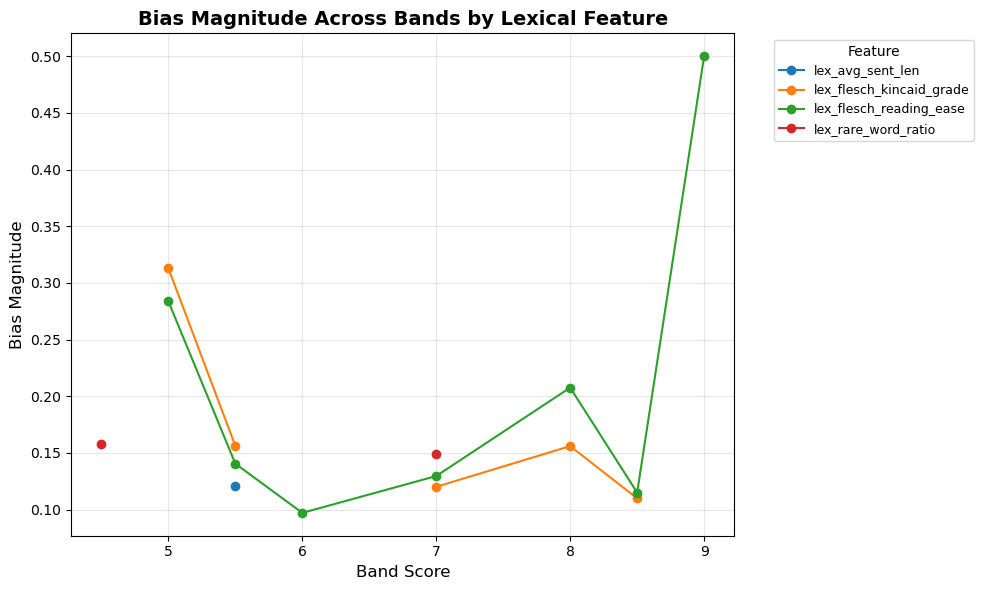

In [ ]:
# Bias Magnitude Across Bands by Lexical Feature Visualization
import pandas as pd
import matplotlib.pyplot as plt

# Data from your LaTeX table
data = [
    ["lex_rare_word_ratio", 4.5, 0.1582],
    ["lex_flesch_kincaid_grade", 5.0, 0.3129],
    ["lex_flesch_reading_ease", 5.0, 0.2837],
    #["syn_subordinate_ratio", 5.0, 0.2323],
    #["syn_avg_tree_depth", 5.0, 0.1956],
    #["syn_verb_ratio", 5.0, 0.1683],
    ["lex_flesch_kincaid_grade", 5.5, 0.1562],
    ["lex_flesch_reading_ease", 5.5, 0.1405],
    ["lex_avg_sent_len", 5.5, 0.1206],
    #["syn_avg_tree_depth", 5.5, 0.1131],
    #["syn_verb_ratio", 5.5, 0.104],
    ["lex_flesch_reading_ease", 6.0, 0.0971],
    #["syn_adj_ratio", 7.0, 0.1498],
    ["lex_rare_word_ratio", 7.0, 0.1492],
    ["lex_flesch_reading_ease", 7.0, 0.1296],
    ["lex_flesch_kincaid_grade", 7.0, 0.1201],
    #["syn_noun_ratio", 7.0, 0.1024],
    #["syn_noun_ratio", 7.5, 0.18],
    ["lex_flesch_reading_ease", 8.0, 0.2076],
    #["syn_adj_ratio", 8.0, 0.1896],
    ["lex_flesch_kincaid_grade", 8.0, 0.156],
    ["lex_flesch_reading_ease", 8.5, 0.115],
    ["lex_flesch_kincaid_grade", 8.5, 0.1099],
    ["lex_flesch_reading_ease", 9.0, 0.5]
]

# Create DataFrame
df = pd.DataFrame(data, columns=["Feature", "Band", "Bias Magnitude"])

# Pivot for plotting (features as separate lines)
pivot_df = df.pivot_table(index="Band", columns="Feature", values="Bias Magnitude")

# Sort bands numerically
pivot_df = pivot_df.sort_index()

# Plot
plt.figure(figsize=(10, 6))
for feature in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[feature], marker='o', label=feature)

# Labels & formatting
plt.title("Bias Magnitude Across Bands by Lexical Feature", fontsize=14, weight='bold')
plt.xlabel("Band Score", fontsize=12)
plt.ylabel("Bias Magnitude", fontsize=12)
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show or save the plot
plt.show()



### 4.3 Cohen's d Effect Size by Band and Feature Visualization

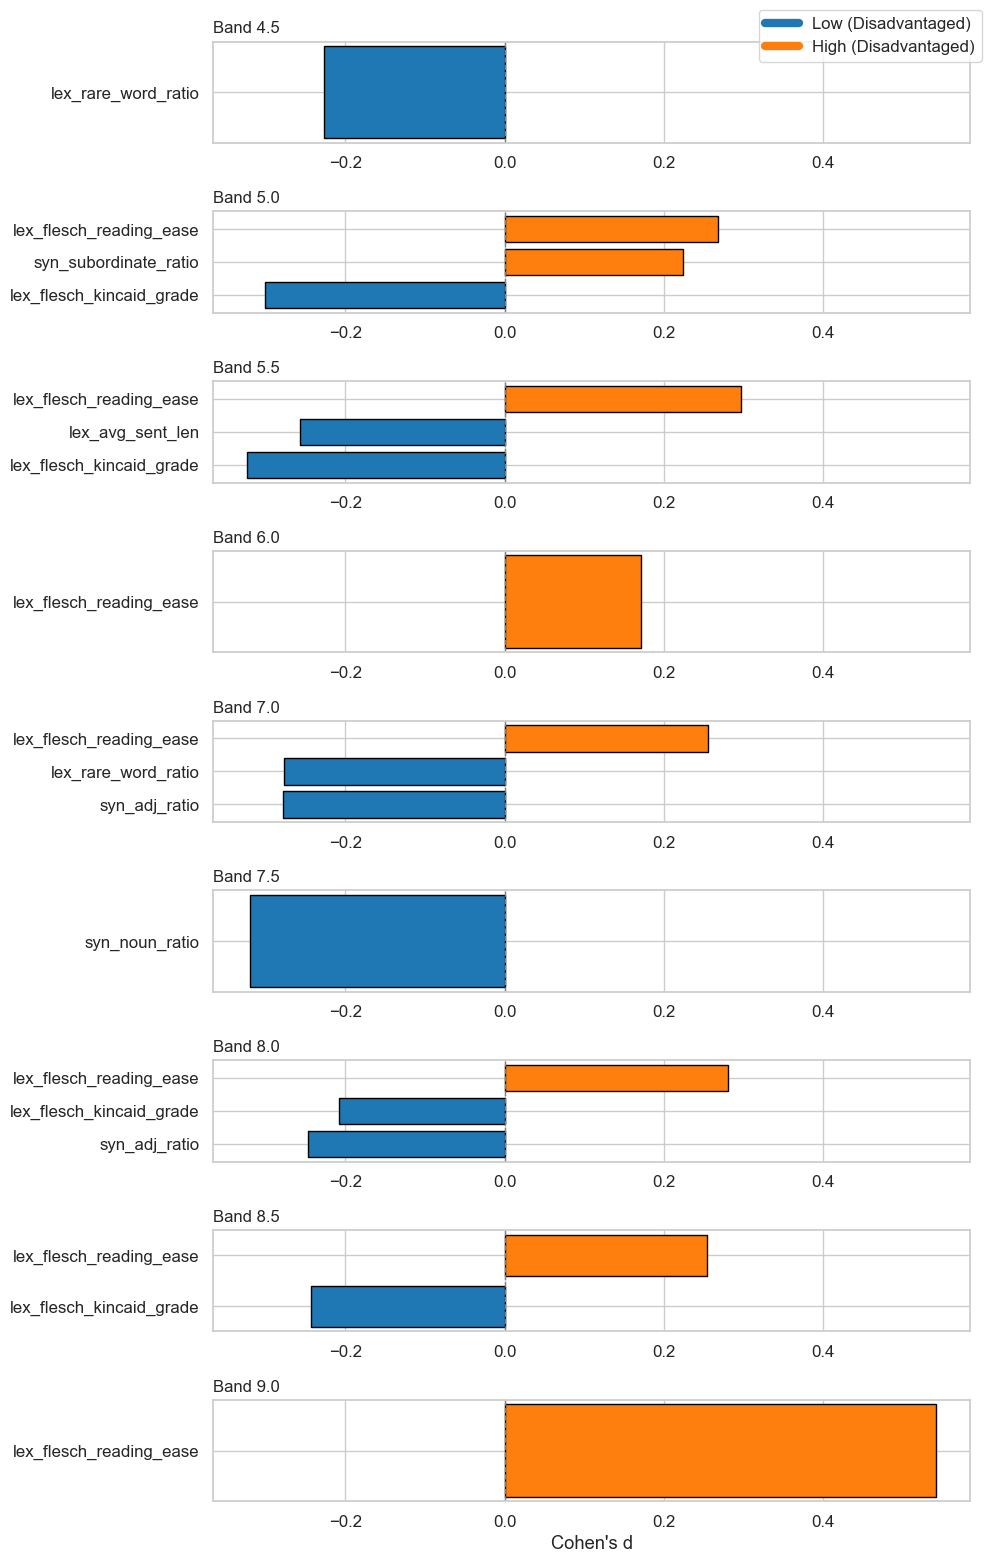

<Figure size 640x480 with 0 Axes>

In [7]:
# Cohen's d Effect Size by Band and Feature Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data from your LaTeX table ---
data = [
    ["lex_rare_word_ratio", 4.5, -0.2269, "Low"],
    ["lex_flesch_kincaid_grade", 5.0, -0.3017, "Low"],
    ["lex_flesch_reading_ease", 5.0, 0.2689, "High"],
    ["syn_subordinate_ratio", 5.0, 0.2244, "High"],
    ["lex_flesch_kincaid_grade", 5.5, -0.3234, "Low"],
    ["lex_flesch_reading_ease", 5.5, 0.2978, "High"],
    ["lex_avg_sent_len", 5.5, -0.2576, "Low"],
    ["lex_flesch_reading_ease", 6.0, 0.1721, "High"],
    ["syn_adj_ratio", 7.0, -0.2789, "Low"],
    ["lex_rare_word_ratio", 7.0, -0.2774, "Low"],
    ["lex_flesch_reading_ease", 7.0, 0.2558, "High"],
    ["syn_noun_ratio", 7.5, -0.32, "Low"],
    ["lex_flesch_reading_ease", 8.0, 0.2809, "High"],
    ["syn_adj_ratio", 8.0, -0.2475, "Low"],
    ["lex_flesch_kincaid_grade", 8.0, -0.2075, "Low"],
    ["lex_flesch_reading_ease", 8.5, 0.2549, "High"],
    ["lex_flesch_kincaid_grade", 8.5, -0.2436, "Low"],
    ["lex_flesch_reading_ease", 9.0, 0.5423, "High"]
]

df = pd.DataFrame(data, columns=["Feature", "Band", "Cohen_d", "Disadvantaged_Group"])

# --- Visualization ---
sns.set(style="whitegrid", font_scale=1.1)

# Create one subplot per band
bands = sorted(df["Band"].unique())
n_bands = len(bands)

fig, axes = plt.subplots(n_bands, 1, figsize=(10, n_bands * 1.8), sharex=True)

for i, band in enumerate(bands):
    ax = axes[i]
    band_df = df[df["Band"] == band].sort_values("Cohen_d")

    # Color by disadvantaged group
    colors = band_df["Disadvantaged_Group"].map({"Low": "#1f77b4", "High": "#ff7f0e"})

    ax.barh(band_df["Feature"], band_df["Cohen_d"], color=colors, edgecolor="black")
    ax.axvline(0, color="gray", linestyle="--", linewidth=1)
    ax.set_title(f"Band {band}", fontsize=12, loc="left")
    ax.set_ylabel("")
    ax.set_xlabel("Cohen's d")

for ax in axes:
    ax.label_outer()  # show outer labels only (default)
    ax.tick_params(labelbottom=True)  # force all to show x-axis ticks


plt.tight_layout(rect=[0, 0, 1, 0.97])

# Create legend manually
handles = [
    plt.Line2D([0], [0], color="#1f77b4", lw=6, label="Low (Disadvantaged)"),
    plt.Line2D([0], [0], color="#ff7f0e", lw=6, label="High (Disadvantaged)")
]
fig.legend(handles=handles, loc="upper right", bbox_to_anchor=(1, 0.97))

plt.show()
plt.savefig("Cohen's d_Effect_Size_by_Band_Feature.png", dpi=300, bbox_inches="tight")


### 4.4 SHAP Visualizations

In [23]:
# === Generate SHAP Visualizations ===
print("\n" + "="*80)
print("Generating SHAP Visualizations")
print("="*80)


try:
    import matplotlib.pyplot as plt
    
    # 1. SHAP Summary Beeswarm Plot (shows feature importance + direction)
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        shap_vals, 
        X_shap,
        plot_type="dot",  # Beeswarm plot
        max_display=15,   # Show top 15 features
        show=False
    )
    plt.title('SHAP Summary Plot - Top 15 Features', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('shap_summary_beeswarm.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✓ Saved: shap_summary_beeswarm.png")

except Exception as e:
    print(f"\n⚠ SHAP visualization failed: {e}")
    import traceback
    traceback.print_exc()


Generating SHAP Visualizations
✓ Saved: shap_summary_beeswarm.png


### 4.5 Correlation Heatmap

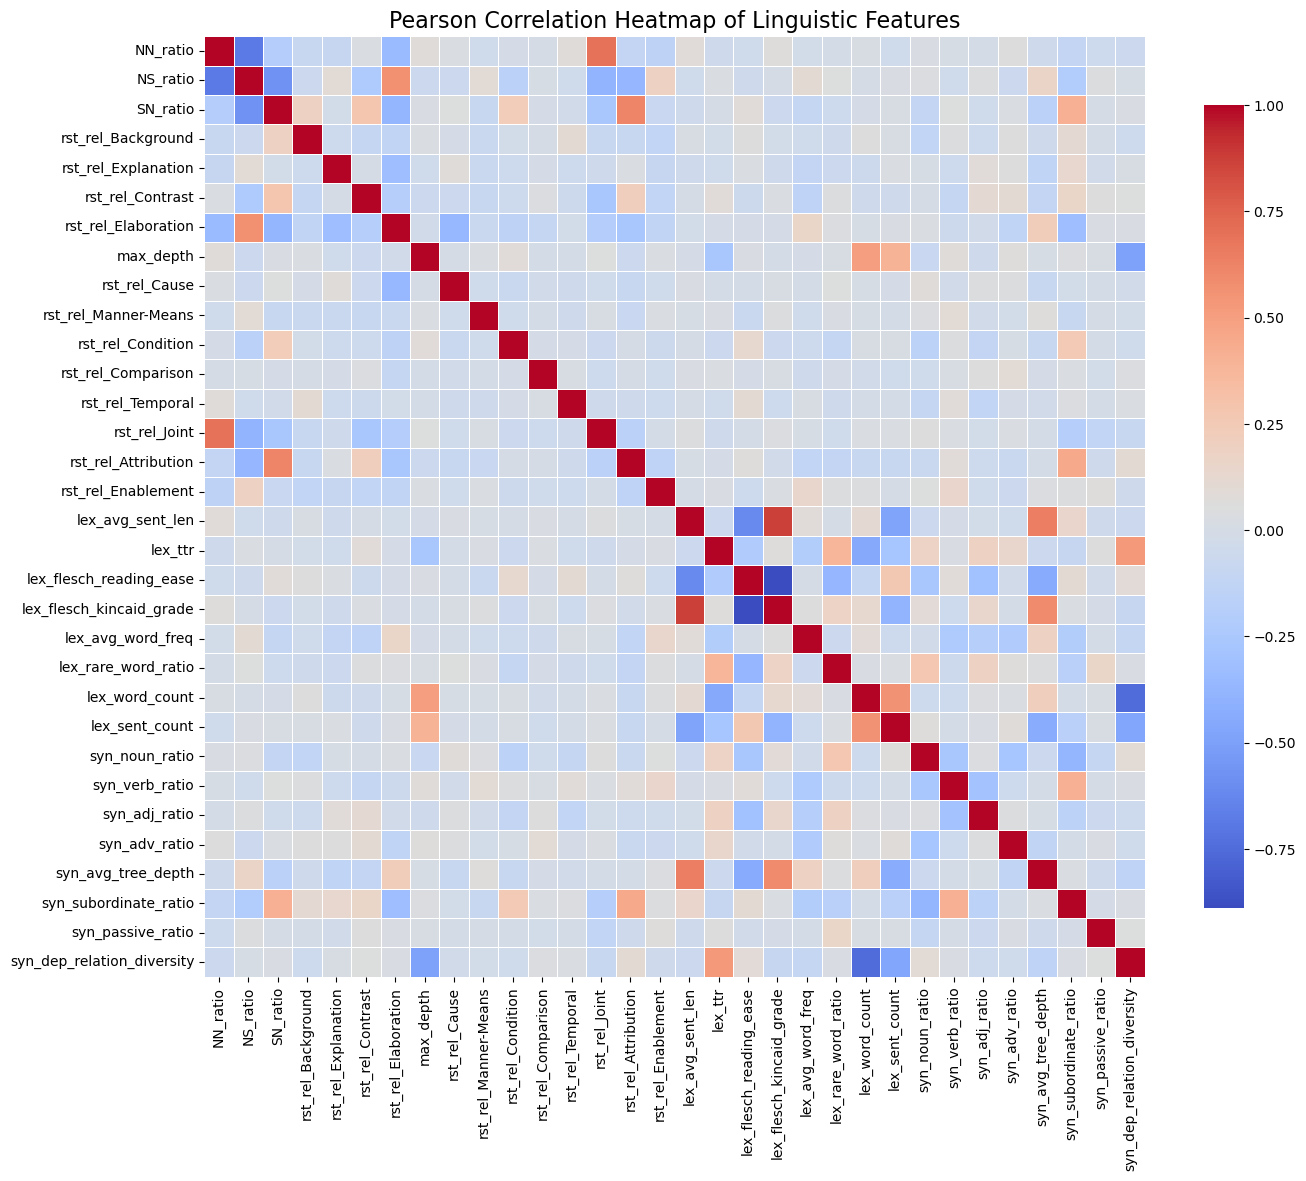

In [ ]:
# === Correlation Heatmap of Linguistic Features ===
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rst_features_corr = ['NN_ratio', 'NS_ratio', 'SN_ratio'] + [
    'rst_rel_Background', 'rst_rel_Explanation', 'rst_rel_Contrast', 'rst_rel_Elaboration', 'max_depth',
    'rst_rel_Cause', 'rst_rel_Manner-Means', 'rst_rel_Condition', 'rst_rel_Comparison',
    'rst_rel_Temporal', 'rst_rel_Joint', 'rst_rel_Attribution', 'rst_rel_Enablement',]
lexical_features_corr = ['lex_avg_sent_len', 'lex_ttr', 'lex_flesch_reading_ease', 
                    'lex_flesch_kincaid_grade', 'lex_avg_word_freq', 'lex_rare_word_ratio', 'lex_word_count', 'lex_sent_count']
syntactic_features_corr = ['syn_noun_ratio', 'syn_verb_ratio', 'syn_adj_ratio', 'syn_adv_ratio',
                      'syn_avg_tree_depth', 'syn_subordinate_ratio', 'syn_passive_ratio',
                      'syn_dep_relation_diversity']

# Combine all features
corr_features = rst_features_corr + lexical_features_corr + syntactic_features_corr

# Load data
df = pd.read_csv('essays_with_systematic_bias_predictions1.csv')

# Subset and compute correlation
corr = df[corr_features].corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", square=True,
            cbar_kws={"shrink": 0.8}, linewidths=0.5)
plt.title('Pearson Correlation Heatmap of Linguistic Features', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 4.6 ROC and PR Curves for Calibration Metrics

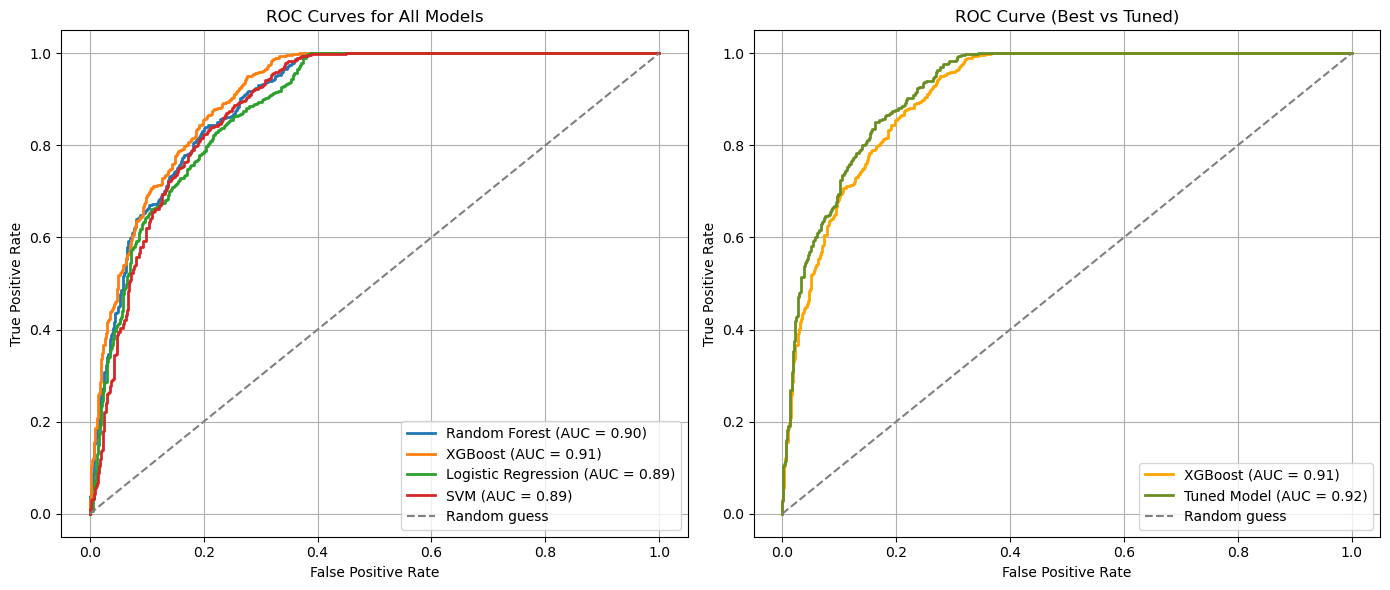

In [ ]:
# === ROC Curve Visualization ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC for tuned model separately
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_test_proba_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_test_proba_tuned)

# Get best model row
best_model_row = results_df.loc[results_df['test_roc_auc'].idxmax()]
best_model_name = best_model_row['model']
best_model_auc = best_model_row['test_roc_auc']
best_fpr, best_tpr, _ = best_model_row['test_roc_curve']

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Subplot 1: All models from results_df ---
for model_name, model_roc_auc, model_roc_curve in zip(
    results_df["model"], results_df["test_roc_auc"], results_df["test_roc_curve"]
):
    fpr, tpr, _ = model_roc_curve
    axes[0].plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {model_roc_auc:.2f})")

# Random guess baseline
axes[0].plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random guess")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves for All Models")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# --- Subplot 2: Best model vs tuned model ---
axes[1].plot(best_fpr, best_tpr, color="orange", lw=2,
             label=f"{best_model_name} (AUC = {best_model_auc:.2f})")
axes[1].plot(fpr_tuned, tpr_tuned, color="olivedrab", lw=2,
             label=f"Tuned Model (AUC = {roc_auc_tuned:.2f})")
axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random guess")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve (Best vs Tuned)")
axes[1].legend(loc="lower right")
axes[1].grid(True)

plt.tight_layout()
plt.show()

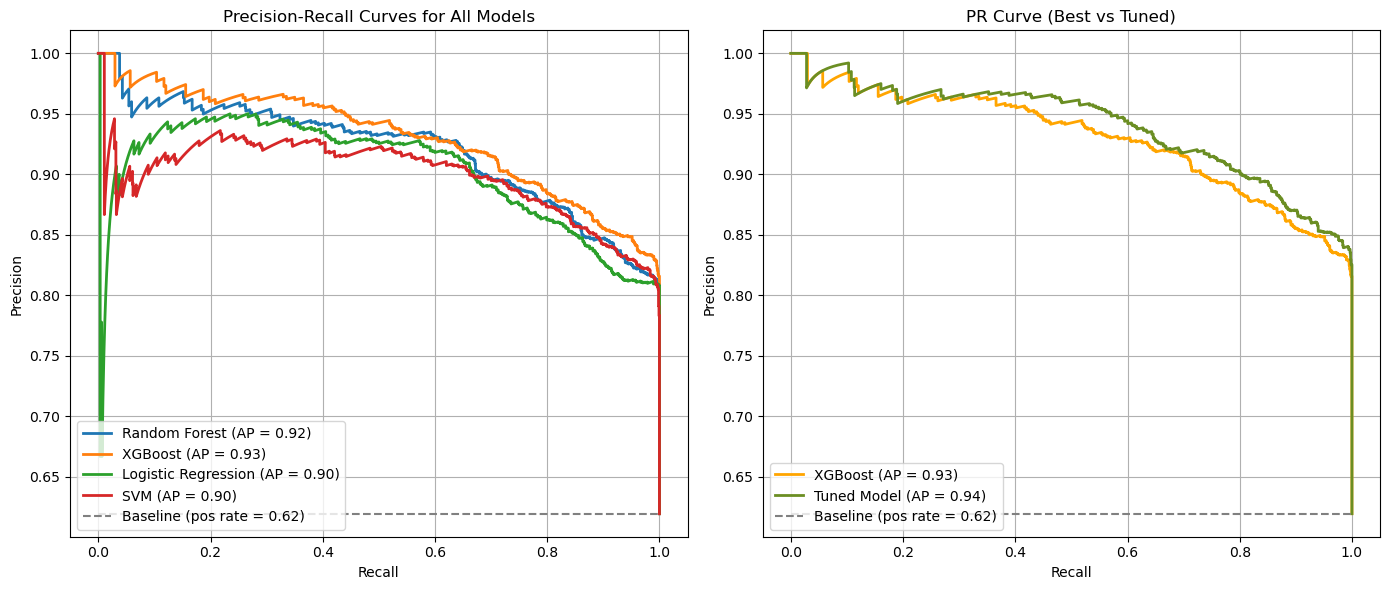

In [ ]:
# Precision-Recall Curve Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute PRC for tuned model separately
prec_tuned, rec_tuned, _ = precision_recall_curve(y_test, y_test_proba_tuned)
ap_tuned = average_precision_score(y_test, y_test_proba_tuned)

# Baseline for PR curve = positive class rate
baseline = y_test.mean()

# Get best model row
best_model_row = results_df.loc[results_df['test_average_precision'].idxmax()]
best_model_name = best_model_row['model']
best_model_ap = best_model_row['test_average_precision']
best_prec, best_rec, _ = best_model_row['test_prc_curve']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Subplot 1: All models ---
for model_name, model_ap, model_prc_curve in zip(
    results_df["model"], results_df["test_average_precision"], results_df["test_prc_curve"]
):
    prec, rec, _ = model_prc_curve
    axes[0].plot(rec, prec, lw=2, label=f"{model_name} (AP = {model_ap:.2f})")

# Baseline
axes[0].plot([0, 1], [baseline, baseline], color="gray", linestyle="--",
             label=f"Baseline (pos rate = {baseline:.2f})")

axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].set_title("Precision-Recall Curves for All Models")
axes[0].legend(loc="lower left")
axes[0].grid(True)

# --- Subplot 2: Best model vs tuned model ---
axes[1].plot(best_rec, best_prec, color="orange", lw=2,
             label=f"{best_model_name} (AP = {best_model_ap:.2f})")

axes[1].plot(rec_tuned, prec_tuned, color="olivedrab", lw=2,
             label=f"Tuned Model (AP = {ap_tuned:.2f})")

axes[1].plot([0, 1], [baseline, baseline], color="gray", linestyle="--",
             label=f"Baseline (pos rate = {baseline:.2f})")

axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("PR Curve (Best vs Tuned)")
axes[1].legend(loc="lower left")
axes[1].grid(True)

plt.tight_layout()
plt.show()


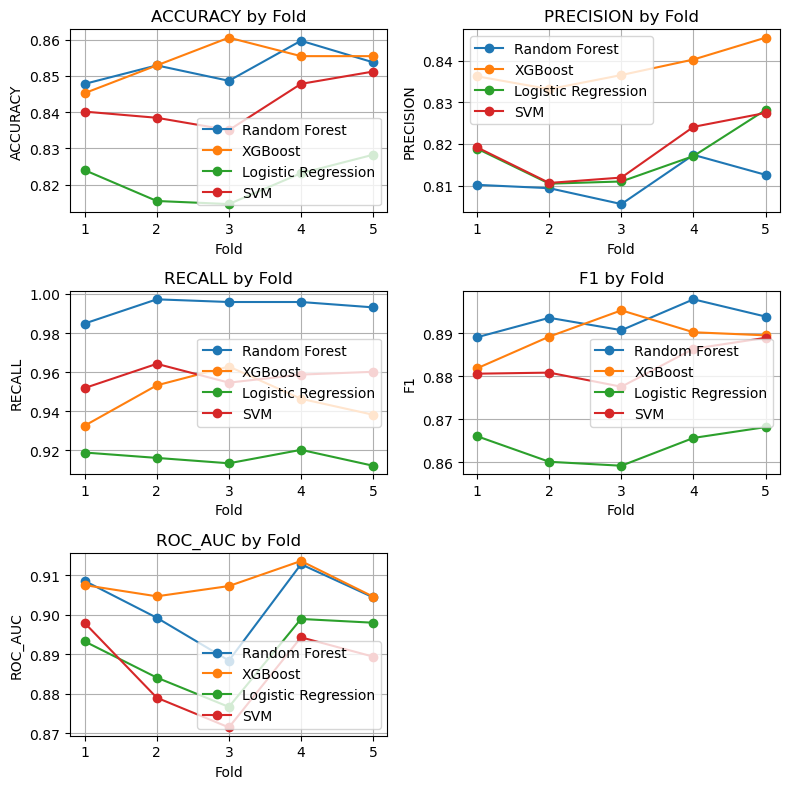

In [ ]:
# # Cross-Validation Metrics Visualization
import matplotlib.pyplot as plt

n_metrics = len(metrics_to_plot)

# Create a 2-row, 3-column grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(8,8))  # 7 width per column, 5 height per row
axes = axes.flatten()  # flatten 2D array into 1D list for easy iteration

# Loop through metrics and corresponding subplot
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    for model_name in cv_df["model"].unique():
        subset = cv_df[cv_df["model"] == model_name]
        ax.plot(subset["fold"], subset[metric], marker="o", label=model_name)

    ax.set_title(f"{metric.upper()} by Fold")
    ax.set_xlabel("Fold")
    ax.set_ylabel(metric.upper())
    ax.legend()
    ax.grid(True)

# Hide any unused subplots if metrics < 6
for j in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

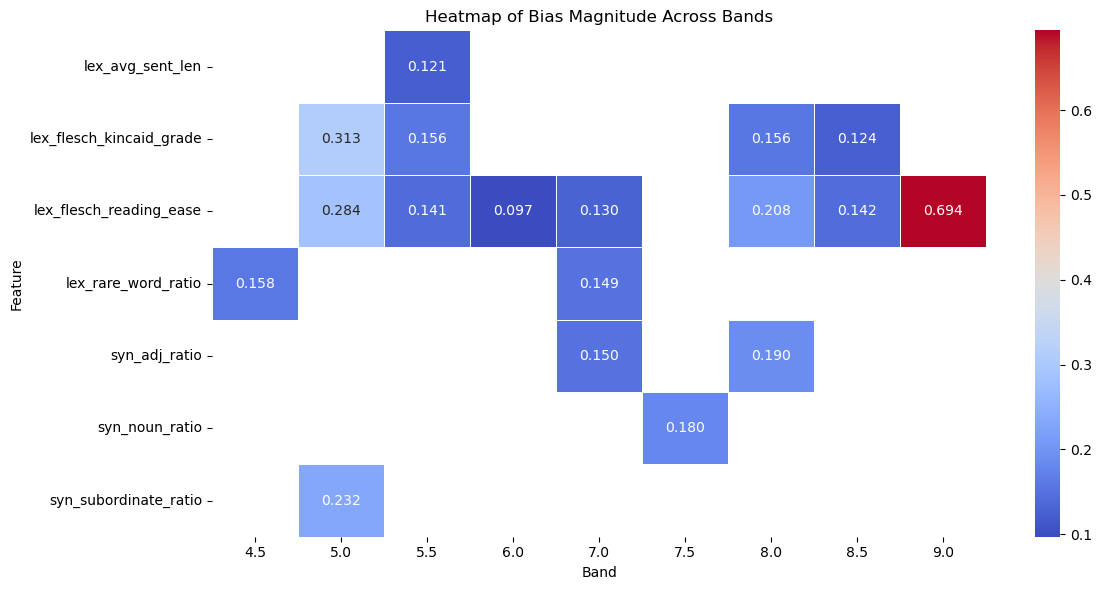

In [ ]:
# Bias Magnitude Heatmap Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame using only the first 3 columns
data = [
    ("lex_rare_word_ratio", 4.5, 0.1582),
    ("lex_flesch_kincaid_grade", 5.0, 0.3129),
    ("lex_flesch_reading_ease", 5.0, 0.2837),
    ("syn_subordinate_ratio", 5.0, 0.2323),
    ("lex_flesch_kincaid_grade", 5.5, 0.1562),
    ("lex_flesch_reading_ease", 5.5, 0.1405),
    ("lex_avg_sent_len", 5.5, 0.1206),
    ("lex_flesch_reading_ease", 6.0, 0.0971),
    ("syn_adj_ratio", 7.0, 0.1498),
    ("lex_rare_word_ratio", 7.0, 0.1492),
    ("lex_flesch_reading_ease", 7.0, 0.1296),
    ("syn_noun_ratio", 7.5, 0.18),
    ("lex_flesch_reading_ease", 8.0, 0.2076),
    ("syn_adj_ratio", 8.0, 0.1896),
    ("lex_flesch_kincaid_grade", 8.0, 0.156),
    ("lex_flesch_reading_ease", 8.5, 0.1424),
    ("lex_flesch_kincaid_grade", 8.5, 0.1242),
    ("lex_flesch_reading_ease", 9.0, 0.694),
]

df = pd.DataFrame(data, columns=["Feature", "Band", "Bias Magnitude"])

# Pivot for heatmap
heatmap_data = df.pivot(index="Feature", columns="Band", values="Bias Magnitude")

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Heatmap of Bias Magnitude Across Bands")
plt.xlabel("Band")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
# === Check Library Versions ===
import sys
import importlib

libraries = {
    "pandas": "pandas",
    "nltk": "nltk",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    "Optuna": "optuna",
    "numpy": "numpy",
    "spacy": "spacy",
    "isanlp": "isanlp",
    "textstat": "textstat",
    "wordfreq": "wordfreq",
    "scikit-learn": "sklearn",
    "shap": "shap",
    "statsmodels": "statsmodels",
    "scipy": "scipy"
}

print(f"Python version: {sys.version}\n")

for display_name, module_name in libraries.items():
    try:
        module = importlib.import_module(module_name)
        version = getattr(module, "__version__", "built-in / no version attribute")
        print(f"{display_name}: {version}")
    except ImportError:
        print(f"{display_name}: NOT INSTALLED")


Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]

pandas: 2.3.2
nltk: 3.9.1
matplotlib: 3.10.6
seaborn: 0.13.2
Optuna: 4.5.0
numpy: 2.2.2
spacy: 3.8.2
isanlp: built-in / no version attribute
textstat: (0, 7, 10)
wordfreq: built-in / no version attribute
scikit-learn: 1.7.2
shap: 0.47.2
statsmodels: 0.14.5
scipy: 1.16.0


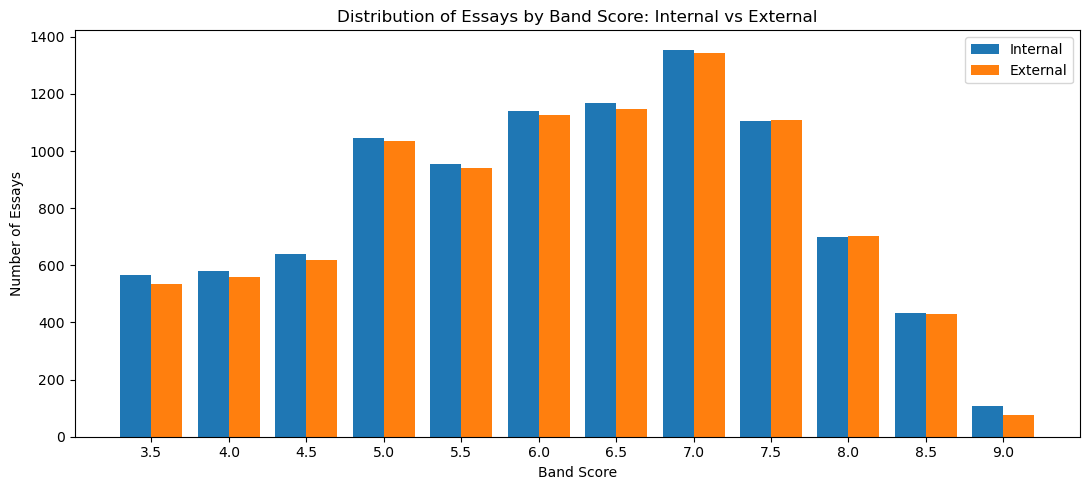

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Internal dataset
internal = {
    "Band": [3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0],
    "Count": [567, 580, 640, 1046, 956, 1142, 1168, 1355, 1105, 700, 433, 108]
}

# External dataset
external = {
    "Band": [3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0],
    "Count": [536, 559, 619, 1037, 940, 1125, 1147, 1344, 1108, 704, 431, 77]
}

df_internal = pd.DataFrame(internal)
df_external = pd.DataFrame(external)

# Bar positions
x = np.arange(len(df_internal["Band"]))
width = 0.4

# Plot
plt.figure(figsize=(11, 5))

plt.bar(
    x - width / 2,
    df_internal["Count"],
    width,
    label="Internal"
)

plt.bar(
    x + width / 2,
    df_external["Count"],
    width,
    label="External"
)

plt.xlabel("Band Score")
plt.ylabel("Number of Essays")
plt.title("Distribution of Essays by Band Score: Internal vs External")
plt.xticks(x, df_internal["Band"])
plt.legend()

plt.tight_layout()
plt.show()


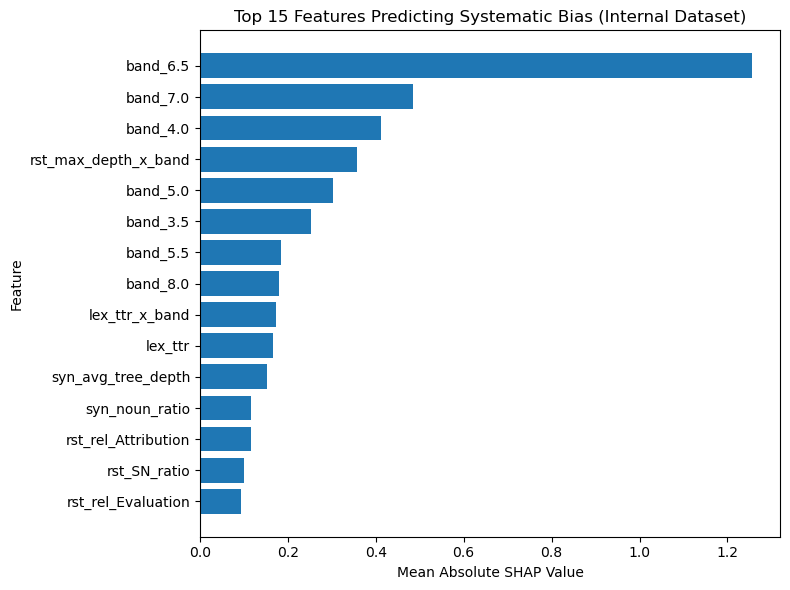

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from the table
data = {
    "Feature": [
        "band_6.5",
        "band_7.0",
        "band_4.0",
        "rst_max_depth_x_band",
        "band_5.0",
        "band_3.5",
        "band_5.5",
        "band_8.0",
        "lex_ttr_x_band",
        "lex_ttr",
        "syn_avg_tree_depth",
        "syn_noun_ratio",
        "rst_rel_Attribution",
        "rst_SN_ratio",
        "rst_rel_Evaluation",
    ],
    "SHAP Importance": [
        1.256658,
        0.484049,
        0.410880,
        0.358273,
        0.303515,
        0.253697,
        0.183586,
        0.181037,
        0.174150,
        0.167216,
        0.151873,
        0.117350,
        0.115766,
        0.100704,
        0.094043,
    ],
}

df = pd.DataFrame(data)

# Sort for plotting (smallest at bottom)
df = df.sort_values("SHAP Importance", ascending=True)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(
    df["Feature"],
    df["SHAP Importance"]
)

plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.title("Top 15 Features Predicting Systematic Bias (Internal Dataset)")

plt.tight_layout()
plt.show()
